In [1]:
import os
import re
import datetime
import tempfile

import numpy as np
import pandas as pd
import scipy.stats as stats
pd.set_option('display.max_columns', 250)
# Don't cut off long string
# http://stackoverflow.com/questions/26277757/pandas-to-html-truncates-string-contents
pd.set_option('display.max_colwidth', -1)

import matplotlib
import matplotlib.pyplot as plt
# matplotlib.style.use('ggplot')
matplotlib.style.use('classic')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (15, 9)

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

In [2]:
from misc.utils import sizeof_fmt

In [3]:
print(datetime.datetime.now().date())

2017-05-04


In [4]:
df0 = pd.read_csv('data/LATEST_MANIFEST.final.tsv.gz', low_memory=False, sep='\t', compression='gzip')

In [5]:
df0.head(1)

,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url
0,TCGA,TCGA-CN-5363-01A-01R-1436-07,HNSC,HEAD AND NECK SQUAMOUS CELL CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,HG19,UNCID_1037354.730eebdc-c67d-4864-8535-6b623cf967a3.sorted_genome_alignments.bam,5.252451e+09,65e18d3b34e6010a7a7fd3a5f809ab31,003c6e42-fc70-44d6-86ac-7f6cd97548e2,730eebdc-c67d-4864-8535-6b623cf967a3,291b069c-9dde-4e1e-8430-85146bc94338,5e4e1e21-8016-4e27-8f72-2411714203e8,CN,NaN,2012-05-03,2012-05-03,2013-05-16,Suppressed,01,R,Illumina HiSeq 2000,bam,This data is being replaced with a newer version of the UNC RNA-Seq pipeline,NaN,NaN,NaN,NaN,NaN,NaN


`RNAseq_FastQC.csv.gz` is exported from https://bigquery.cloud.google.com/table/isb-cgc:tcga_seq_metadata.RNAseq_FastQC

In [6]:
df1 = pd.read_csv('data/RNAseq_FastQC.csv.gz', compression='gzip')

In [7]:
df1.head(1)

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,PerBaseSeqQual,PBSQ10_0,PBSQ50_0,PBSQ10_1,PBSQ50_1,PBSQ10_2,PBSQ50_2,PBSQ10_3,PBSQ50_3,PBSQ10_4,PBSQ50_4,PBSQ10_5,PBSQ50_5,PBSQ10_6,PBSQ50_6,PBSQ10_7,PBSQ50_7,PBSQ10_8,PBSQ50_8,PBSQ10_9,PBSQ50_9,PBSQ10_10,PBSQ50_10,PerTileSeqQual,PerSeqQualScore,PSQC_0,PSQC_1,PSQC_2,PSQC_3,PSQC_4,PSQC_5,PSQC_6,PSQC_7,PSQC_8,PSQC_9,PSQC_10,PerBaseSeqCont,PBSC_G_0,PBSC_A_0,PBSC_T_0,PBSC_C_0,PBSC_G_1,PBSC_A_1,PBSC_T_1,PBSC_C_1,PBSC_G_2,PBSC_A_2,PBSC_T_2,PBSC_C_2,PBSC_G_3,PBSC_A_3,PBSC_T_3,PBSC_C_3,PBSC_G_4,PBSC_A_4,PBSC_T_4,PBSC_C_4,PBSC_G_5,PBSC_A_5,PBSC_T_5,PBSC_C_5,PBSC_G_6,PBSC_A_6,PBSC_T_6,PBSC_C_6,PBSC_G_7,PBSC_A_7,PBSC_T_7,PBSC_C_7,PBSC_G_8,PBSC_A_8,PBSC_T_8,PBSC_C_8,PBSC_G_9,PBSC_A_9,PBSC_T_9,PBSC_C_9,PBSC_G_10,PBSC_A_10,PBSC_T_10,PBSC_C_10,PerSeqGCcont,PSGCC_0,PSGCC_1,PSGCC_2,PSGCC_3,PSGCC_4,PSGCC_5,PSGCC_6,PSGCC_7,PSGCC_8,PSGCC_9,PSGCC_10,PerBaseNcont,PBNC_1,PBNC_2,PBNC_3,PBNC_4,PBNC_5,PBNC_6,PBNC_7,PBNC_8,PBNC_9,PBNC_10,SeqLenDist,SLD_modeVal,SLD_neg10,SLD_neg9,SLD_neg8,SLD_neg7,SLD_neg6,SLD_neg5,SLD_neg4,SLD_neg3,SLD_neg2,SLD_neg1,SLD_mode,SLD_pos1,SLD_pos2,SLD_pos3,SLD_pos4,SLD_pos5,SLD_pos6,SLD_pos7,SLD_pos8,SLD_pos9,SLD_pos10,SeqDupLev,Total_Dedup_Pct,Dedup_relPct_1,Dedup_relPct_2,Dedup_relPct_3,Dedup_relPct_4,Dedup_relPct_5,Dedup_relPct_6,Dedup_relPct_7,Dedup_relPct_8,Dedup_relPct_9,Dedup_relPct_ge10,Dedup_relPct_ge50,Dedup_relPct_ge100,Dedup_relPct_ge500,Dedup_relPct_ge1k,Dedup_relPct_ge5k,Dedup_relPct_ge10k,OverrepSeq,OverRepSeq_1,OverRepSeq_1_Pct,OverRepSeq_2,OverRepSeq_2_Pct,OverRepSeq_3,OverRepSeq_3_Pct,AdaptCont,KmerCont,Kmer_Seq_1,Kmer_Ratio_1,Kmer_Seq_2,Kmer_Ratio_2,Kmer_Seq_3,Kmer_Ratio_3,Kmer_Ratio_Min,Kmer_Num_Seq
0,00065a62-5e18-4223-a884-12fca053a109,TCGA-2Z-A9J3-01A-12R-A38C-07,140516_UNC12-SN629_0369_AC4GGKACXX_GGCTAC_L002_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/KIRP/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/00065a62-5e18-4223-a884-12fca053a109-140516_UNC12-SN629_0369_AC4GGKACXX_GGCTAC_L002_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/KIRP/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/00065a62-5e18-4223-a884-12fca053a109-140516_UNC12-SN629_0369_AC4GGKACXX_GGCTAC_L002_1_fastqc.zip,pass,78492984,0,48,48,1,50,pass,31,34,35.0,37,35.0,39.0,36.0,40.0,35.0,40.0,35.0,40.0,35.0,40.0,34.0,40.0,34.0,40.0,33.0,40.0,31,38,pass,pass,2,34,36,37,38,38,39,39,39,39,39,fail,27.53003,12.408029,17.071692,42.990249,23.629694,33.048944,20.767008,22.554355,23.770993,34.710779,21.8498,19.668428,24.409745,24.892885,25.559626,25.137745,25.024649,24.871529,25.20849,24.895332,24.597984,25.573245,25.093488,24.735283,25.257113,25.034442,24.996694,24.711751,25.14993,24.964309,24.835695,25.050066,24.531676,25.426731,25.08686,24.954734,24.619681,25.010791,25.409735,24.959794,24.438681,25.514561,25.489523,24.557236,pass,0,34,39,43,47,50,54,57,61,66,100,pass,0.074186,0.002505,0.002519,0.012485,0.007138,0.006976,0.038672,0.018324,0.000837,0.000001,pass,48,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,fail,34.622958,24.206718,9.243894,5.809638,4.151374,3.126133,2.535093,2.090047,1.773165,1.452206,17.49137,5.38317,10.216731,3.750783,7.068727,1.041764,0.659186,warn,GATCGGAAGAGCACACGTCTGAACTCCAGTCACGGCTACATCTCGTAT,0.246763,AGATCGGAAGAGCACACGTCTGAACTCCAGTCACGGCTACATCTCGTA,0.1658,NaN,NaN,pass,fail,CTCGTAT,34.167786,AGATCGG,28.136084,TCTCGTA,20.962118,16.753263,21


`GCS_listing_27apr2016.csv.gz` is exported from https://bigquery.cloud.google.com/table/isb-cgc:tcga_seq_metadata.GCS_listing_27apr2016

In [8]:
df2 = pd.read_csv('data/GCS_listing_27apr2016.csv.gz', compression='gzip')

In [9]:
df2['pretty_size'] = df2.objectSizeBytes.apply(sizeof_fmt)

In [10]:
df2.head(1)

,CGHubAnalysisID,AliquotBarcode,AliquotUUID,GCSobject,objectSizeBytes,pretty_size
0,00007994-abeb-4b16-a6ad-7230300a29e9,TCGA-AA-3495-01A-01R-1410-07,c18465ae-447d-46c8-8b54-0156ab502265,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_1620885.c18465ae-447d-46c8-8b54-0156ab502265.sorted_genome_alignments.bam,1972948726,1.8GB


In [11]:
print(df0.shape)
print(df1.shape)
print(df2.shape)

(128399, 37)
(22408, 174)
(83451, 6)


In [12]:
df0.analysis_id.unique().shape

(128189,)

In [13]:
ndf = df1.merge(df0, left_on='CGHub_analysisID', right_on='analysis_id')

In [14]:
ndf = ndf.merge(df2, left_on=['CGHub_analysisID', 'AliquotBarcode'], right_on=['CGHubAnalysisID', 'AliquotBarcode'])

In [15]:
ndf.analysis_id.unique().shape

(11340,)

In [16]:
ndf.shape

(22408, 216)

In [17]:
ndf.columns.values[:20]

array(['CGHub_analysisID', 'AliquotBarcode', 'fastqFilename',
       'FastQC_html_url', 'FastQC_zip_url', 'BasicStats', 'numTotalSeq',
       'numPoorSeq', 'minLength', 'maxLength', 'delLength', 'pctGC',
       'PerBaseSeqQual', 'PBSQ10_0', 'PBSQ50_0', 'PBSQ10_1', 'PBSQ50_1',
       'PBSQ10_2', 'PBSQ50_2', 'PBSQ10_3'], dtype=object)

## Verified that not a single poor read was found

In [18]:
ndf.numPoorSeq.value_counts()

0    22408
Name: numPoorSeq, dtype: int64

In [19]:
ndf.FastQC_html_url.head(1)

0    https://storage.cloud.google.com/isb-cgc-open/tcga-qc/KIRP/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/00065a62-5e18-4223-a884-12fca053a109-140516_UNC12-SN629_0369_AC4GGKACXX_GGCTAC_L002_1_fastqc.html
Name: FastQC_html_url, dtype: object

In [20]:
ndf.PerBaseSeqQual.value_counts()

pass    20427
fail    1945 
warn    36   
Name: PerBaseSeqQual, dtype: int64

#### Add some handy columns

In [21]:
ndf['handy_disease_names'] = ndf.apply(lambda x: '{0}: {1}'.format(
        x.disease, ' '.join([_.capitalize() for _ in x.disease_name.split()])), axis=1)

In [22]:
# Drop columns that are not interested at the moment
cols = ndf.columns.values
cols_to_drop = [_ for _ in cols if re.search('^Per|^PBSQ|^PSQC|^PBSC|^PSGCC|^PBNC|^SLD_|^Dedup_|^OverRepSeq|^Kmer_', _)]
ndf.drop(cols_to_drop, axis=1, inplace=True)

In [23]:
ndf[ndf.filename.str.contains('UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz')]

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names
12268,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,TCGA-P6-A5OF-01A-11R-A29S-07,130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_1_fastqc.zip,pass,72562760,0,48,48,1,49,pass,fail,38.184442,warn,pass,fail,TCGA,TCGA-P6-A5OF-01A-11R-A29S-07,ACC,ADRENOCORTICAL CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6.513721e+09,b662e7d30ed31b4e9b815bf074dd0d63,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,888a7158-2319-4563-849b-573705c72ab7,42e0c347-e8d1-4490-a6bb-8a43e5a21013,P6,NaN,2013-09-25,2013-09-25,2013-09-25,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6513721325,6.1GB,ACC: Adrenocortical Carcinoma
12269,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,TCGA-P6-A5OF-01A-11R-A29S-07,130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/8b846cc9-2c7b-4445-aa7e-c9b5af8beedd-130807_UNC12-SN629_0325_BD2BD7ACXX_TTAGGC_L008_2_fastqc.zip,pass,72562760,0,48,48,1,49,pass,fail,39.669957,pass,pass,fail,TCGA,TCGA-P6-A5OF-01A-11R-A29S-07,ACC,ADRENOCORTICAL CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6.513721e+09,b662e7d30ed31b4e9b815bf074dd0d63,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,888a7158-2319-4563-849b-573705c72ab7,42e0c347-e8d1-4490-a6bb-8a43e5a21013,P6,NaN,2013-09-25,2013-09-25,2013-09-25,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8b846cc9-2c7b-4445-aa7e-c9b5af8beedd,ca5f547a-8ec9-4436-9878-1f1cab2fa329,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/ACC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2202571.ca5f547a-8ec9-4436-9878-1f1cab2fa329.130807_UNC12-SN629_0325_BD2BD7ACXX_8_TTAGGC.tar.gz,6513721325,6.1GB,ACC: Adrenocortical Carcinoma


## Verify normal & tumour have the same sequencing depth

In [24]:
ndf['sstype'] = ndf.sample_type_name.apply(lambda x: 'normal' if x == 'Solid Tissue Normal' else 'tumour')

In [25]:
# _df = ndf.groupby('disease').apply(lambda g: g.sstype.unique().shape[0] > 1)

In [26]:
# cancer types with the most normal samples (>20 + BLCA & ESCA to fill up the subplots)
diseases_with_normal = interested_diseases = [
    'BRCA', 'COAD', 'KICH',
    'KIRC', 'KIRP', 'LIHC',
    'LUAD', 'LUSC', 'THCA',
    'HNSC', 'STAD', 'UCEC',
    'PRAD', 'BLCA',
    # 'ESCA'
]

In [27]:
grped = ndf[ndf.disease.isin(diseases_with_normal)].groupby(['disease', 'sstype'])

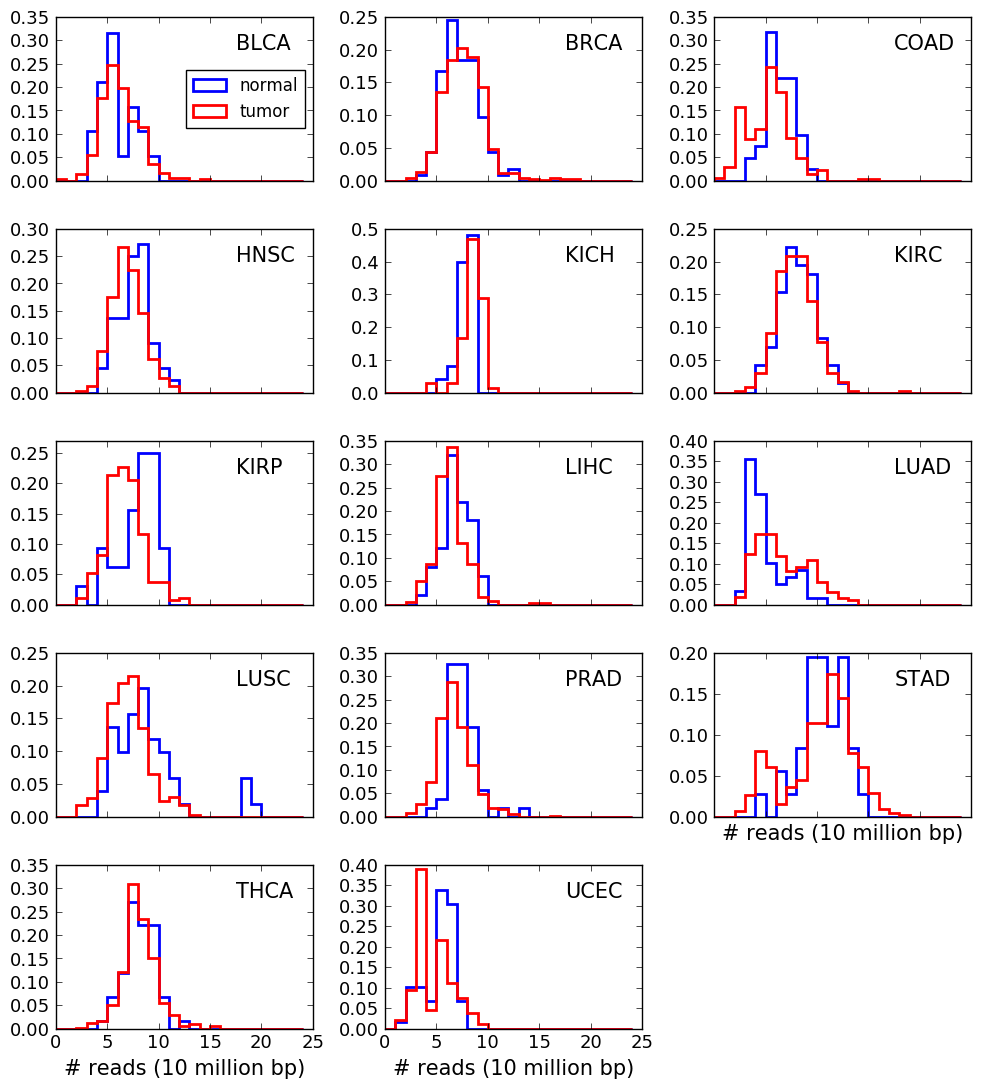

In [35]:
fig, axes = plt.subplots(5, 3, sharex=True, sharey=False, figsize=(10, 11))
axes = axes.ravel()

bins = np.arange(0, 2.5e8, 1e7)
bins /= 1e7

for k, disease in enumerate(sorted(diseases_with_normal)):
    ax = axes[k]
    for sstype in ['normal', 'tumour']:
        color = 'blue' if sstype == 'normal' else 'red'
        _df = ndf[(ndf.disease == disease) & (ndf.sstype == sstype)]
        ax.hist(_df.numTotalSeq.values / 1e7, bins=bins, color=color, alpha=1, normed=True,
                histtype='step', lw=2, label=sstype.replace('tumour', 'tumor'))
    ax.text(0.7, 0.8, disease, fontsize=15, transform=ax.transAxes)
    if k == 0:
        ax.legend(loc='center right')
#     if k % 3 == 0:
#         ax.set_ylabel('# samples', fontsize=15)
    if k + 1 >= 12:
        ax.set_xlabel('# reads (10 million bp)', fontsize=15)
    
    if disease == 'KIRP':
        ax.set_ylim(0, 0.27)

    ax.tick_params(axis='both', which='major', labelsize=13)
    
for i in range(14, 15):
    axes[i].patch.set_facecolor('white')
    axes[i].axis('off')    
plt.tight_layout()
plt.savefig('/projects/btl/zxue/tasrkleat-TCGA-results/apa_manuscript/figs/verified-normal-tumour-samples-have-similar-sequencing-depth-normed.jpg', dpi=300)

Without normalizing y axis

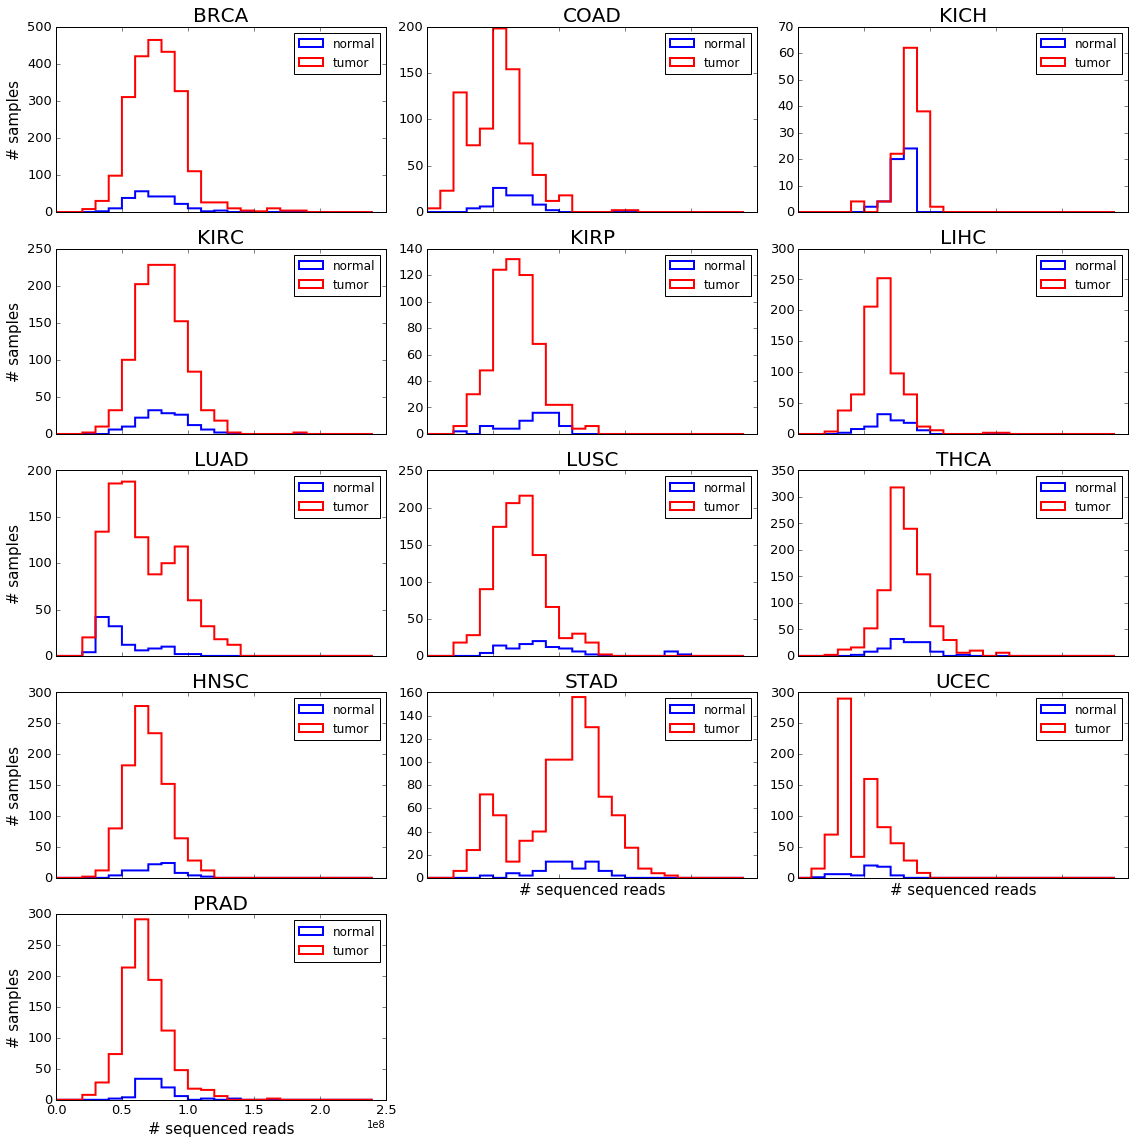

In [87]:
fig, axes = plt.subplots(5, 3, sharex=True, sharey=False, figsize=(16, 16))
axes = axes.ravel()

bins = np.arange(0, 2.5e8, 1e7)

for k, disease in enumerate(diseases_with_normal):
    ax = axes[k]
    for sstype in ['normal', 'tumour']:
        color = 'blue' if sstype == 'normal' else 'red'
        _df = ndf[(ndf.disease == disease) & (ndf.sstype == sstype)]
        ax.hist(_df.numTotalSeq.values, bins=bins, color=color, alpha=1, 
                histtype='step', lw=2, label=sstype.replace('tumour', 'tumor'))
    ax.set_title(disease, fontsize=20)
    ax.legend(loc='upper right')
    if k % 3 == 0:
        ax.set_ylabel('# samples', fontsize=15)
    if k >= 10:
        ax.set_xlabel('# sequenced reads', fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=13)
    
for i in range(13, 15):
    axes[i].patch.set_facecolor('white')
    axes[i].axis('off')    
plt.tight_layout()
plt.savefig('/projects/btl/zxue/tasrkleat-TCGA-results/figs/verified-normal-tumour-samples-have-similar-sequencing-depth.png', dpi=100)

In [79]:
# t-test, may not applym, left here fore future references

# norm_vals = ndf.query('disease == "BRCA"').query('sstype == "normal"').numTotalSeq.values
# norm_vals = norm_vals - np.min(norm_vals)
# norm_vals = norm_vals.reshape(-1, 1)

# tumo_vals = ndf.query('disease == "BRCA"').query('sstype == "tumour"').numTotalSeq.values
# tumo_vals = tumo_vals - np.min(tumo_vals)
# tumo_vals = tumo_vals.reshape(-1, 1)

# stats.ttest_ind(norm_vals, tumo_vals)

# norm_vals = ndf.query('disease == "BRCA"').query('sstype == "normal"').numTotalSeq.values.reshape(-1, 1)
# tumo_vals = ndf.query('disease == "BRCA"').query('sstype == "tumour"').numTotalSeq.values.reshape(-1, 1)

# stats.ttest_ind(norm_vals, tumo_vals, equal_var=False)

# for k, disease in enumerate(diseases_with_normal):
#     norm_vals = ndf.query('disease == "{0}"'.format(disease)).query('sstype == "normal"').numTotalSeq.values
#     tumo_vals = ndf.query('disease == "{0}"'.format(disease)).query('sstype == "tumour"').numTotalSeq.values
#     print(disease, '{0:5f}'.format(stats.ttest_ind(norm_vals, tumo_vals, equal_var=False)[1]))

In [68]:
for k, disease in enumerate(diseases_with_normal):
    norm_vals = ndf.query('disease == "{0}"'.format(disease)).query('sstype == "normal"').numTotalSeq.values
    tumo_vals = ndf.query('disease == "{0}"'.format(disease)).query('sstype == "tumour"').numTotalSeq.values
    print(disease, '{0:5f}'.format(stats.ks_2samp(norm_vals, tumo_vals)[1]))
#     print(disease, stats.ks_2samp(norm_vals, tumo_vals))

BRCA 0.011716
COAD 0.000007
KICH 0.000030
KIRC 0.008592
KIRP 0.000000
LIHC 0.000001
LUAD 0.000000
LUSC 0.000000
THCA 0.597105
HNSC 0.000035
STAD 0.079577
UCEC 0.000019
PRAD 0.000000
BLCA 0.015781
ESCA 0.481856


In [28]:
ms_df = grped.apply(lambda g: pd.Series([g.numTotalSeq.mean(), g.numTotalSeq.std()], index=['mean', 'std'])).reset_index().pivot(index='disease', columns='sstype').T[diseases_with_normal]

In [29]:
ms_df.applymap('{:,.3g}'.format)

disease          BRCA      COAD      KICH      KIRC      KIRP      LIHC      LUAD      LUSC      THCA      HNSC      STAD      UCEC      PRAD      BLCA      ESCA
     sstype                                                                                                                                                      
mean normal  7.38e+07  6.41e+07  7.89e+07  8.19e+07  7.93e+07  6.93e+07  5.03e+07  8.99e+07  8.16e+07  7.59e+07  1.06e+08  5.33e+07  7.51e+07  5.91e+07  1.22e+08
     tumour  7.68e+07  5.36e+07  8.45e+07  7.94e+07  6.74e+07  6.31e+07  6.68e+07  7.07e+07  8.13e+07  6.99e+07  1.03e+08  4.68e+07  6.8e+07   6.27e+07  1.21e+08
std  normal  1.7e+07   1.4e+07   8.61e+06  1.73e+07  1.96e+07  1.4e+07   1.88e+07  3.49e+07  1.46e+07  1.54e+07  2.19e+07  1.47e+07  1.47e+07  1.64e+07  1.88e+07
     tumour  2.01e+07  2.13e+07  1.05e+07  1.83e+07  1.75e+07  1.49e+07  2.52e+07  1.98e+07  1.69e+07  1.55e+07  3.28e+07  1.78e+07  1.68e+07  1.8e+07   1.86e+07

In [30]:
mean = ms_df.loc['mean'].T
std = ms_df.loc['std'].T
lrg = stats.linregress(mean.normal.values, mean.tumour.values)

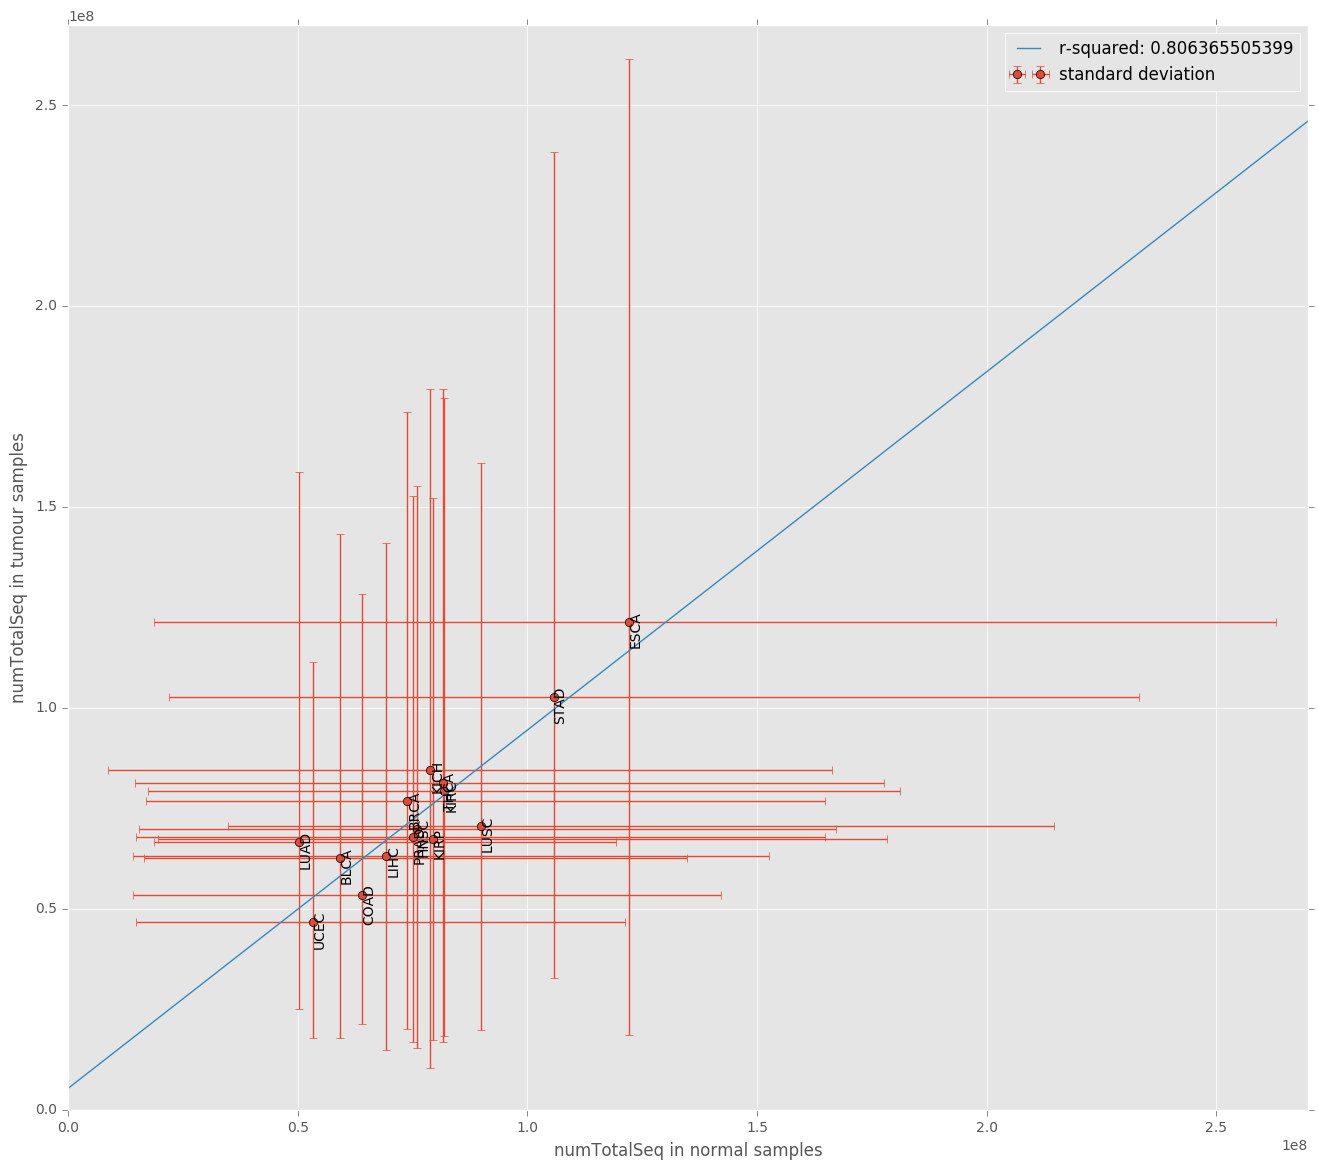

In [31]:
fig = plt.figure(figsize=(16, 14))
ax = fig.add_subplot(111)
# ax = ms_df.loc['mean'].T.plot.scatter(x='normal', y='tumour')
ax = plt.axes()
ax.errorbar(mean['normal'].values, mean['tumour'].values, fmt='o', label='standard deviation',
            xerr=[mean.normal.values - std.normal.values, mean.normal.values + std.normal.values],
            yerr=[mean.tumour.values - std.tumour.values, mean.tumour.values + std.tumour.values])
ax.set_xlabel('numTotalSeq in normal samples')
ax.set_ylabel('numTotalSeq in tumour samples')

xs = np.array([0, 3e8])
ax.plot(xs, xs * lrg.slope + lrg.intercept, label='r-squared: {0}'.format(lrg.rvalue**2))

ax.legend()
ax.set_xlim(0, 2.7e8)
ax.set_ylim(0, 2.7e8)

for idx, row in mean.iterrows():
    ax.text(row.normal, row.tumour, idx, rotation=90)

plt.savefig('/projects/btl/zxue/tasrkleat-TCGA-results/figs/verified-normal-tumour-samples-have-similar-sequencing-depth-line.png', dpi=100)

## Centers that produce RNA-Seq data

In [32]:
ndf.library_type.unique()

array(['RNA-Seq'], dtype=object)

In [33]:
ndf[ndf.library_type == 'RNA-Seq'].center.value_counts()

UNC-LCCC    19238
BCCAGSC     2830 
BI          340  
Name: center, dtype: int64

In [34]:
unc_df = ndf[ndf.center == 'UNC-LCCC']
gsc_df = ndf[ndf.center == 'BCCAGSC']
bi_df = ndf[ndf.center == 'BI']

#### By disease

In [35]:
unc_df.handy_disease_names.value_counts()

BRCA: Breast Invasive Carcinoma                                           2512
KIRC: Kidney Renal Clear Cell Carcinoma                                   1236
LUAD: Lung Adenocarcinoma                                                 1202
THCA: Thyroid Carcinoma                                                   1144
HNSC: Head And Neck Squamous Cell Carcinoma                               1132
PRAD: Prostate Adenocarcinoma                                             1116
LUSC: Lung Squamous Cell Carcinoma                                        1110
LGG: Brain Lower Grade Glioma                                             1068
SKCM: Skin Cutaneous Melanoma                                             946 
COAD: Colon Adenocarcinoma                                                900 
BLCA: Bladder Urothelial Carcinoma                                        866 
LIHC: Liver Hepatocellular Carcinoma                                      848 
UCEC: Uterine Corpus Endometrioid Carcinoma         

In [36]:
gsc_df.handy_disease_names.value_counts()

STAD: Stomach Adenocarcinoma             968
OV: Ovarian Serous Cystadenocarcinoma    858
LAML: Acute Myeloid Leukemia             608
ESCA: Esophageal Carcinoma               396
Name: handy_disease_names, dtype: int64

In [37]:
bi_df.handy_disease_names.value_counts()

GBM: Glioblastoma Multiforme    340
Name: handy_disease_names, dtype: int64

#### By sample type

In [38]:
unc_df.sample_type_name.value_counts()

Primary solid Tumor         16997
Solid Tissue Normal         1373 
Metastatic                  786  
Recurrent Solid Tumor       58   
Additional - New Primary    22   
Additional Metastatic       2    
Name: sample_type_name, dtype: int64

In [39]:
gsc_df.sample_type_name.value_counts()

Primary solid Tumor                                2106
Primary Blood Derived Cancer - Peripheral Blood    608 
Solid Tissue Normal                                98  
Recurrent Solid Tumor                              16  
Metastatic                                         2   
Name: sample_type_name, dtype: int64

In [40]:
bi_df.sample_type_name.value_counts()

Primary solid Tumor      314
Recurrent Solid Tumor    26 
Name: sample_type_name, dtype: int64

#### by platform full names

In [41]:
ndf.platform_full_name.value_counts()

Illumina HiSeq 2000             20968
Illumina Genome Analyzer IIx    736  
Illumina Genome Analyzer II     648  
Illumina HiSeq 2500             56   
Name: platform_full_name, dtype: int64

In [42]:
unc_df.platform_full_name.value_counts()

Illumina HiSeq 2000            18590
Illumina Genome Analyzer II    648  
Name: platform_full_name, dtype: int64

In [43]:
gsc_df.platform_full_name.value_counts()

Illumina HiSeq 2000             2038
Illumina Genome Analyzer IIx    736 
Illumina HiSeq 2500             56  
Name: platform_full_name, dtype: int64

In [44]:
bi_df.platform_full_name.value_counts()

Illumina HiSeq 2000    340
Name: platform_full_name, dtype: int64

### Some verification

In [45]:
for col in ['study', 'library_type', 'state', 'file_type']:
    print(ndf[col].value_counts())
    print

TCGA    22408
Name: study, dtype: int64

RNA-Seq    22408
Name: library_type, dtype: int64

Live    22408
Name: state, dtype: int64

fasta    22408
Name: file_type, dtype: int64



#### Drop analysis ids with inconsistent read length

In [46]:
ndf.delLength.value_counts()

1     22407
45    1    
Name: delLength, dtype: int64

In [47]:
ndf[ndf.delLength == 45]

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,sstype
3462,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,TCGA-AB-2909-03A-01T-0744-13,61YETAAXX_1_ATCACG_2.fastq.gz,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_2_fastqc.zip,pass,83121778,0,6,50,45,47,warn,fail,0.410745,fail,pass,warn,TCGA,TCGA-AB-2909-03A-01T-0744-13,LAML,ACUTE MYELOID LEUKEMIA,TB,Primary Blood Derived Cancer - Peripheral Blood,Total RNA,RNA-Seq,BCCAGSC,NaN,ILLUMINA,Illumina,unaligned,TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6.494423e+09,6924e520152b16158c3ea24ef20550af,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,ab60901b-d2ad-401a-9742-52df35ce1de0,40168b34-bbfe-4ee2-b7b5-2e33fbf64a18,AB,SRS131131,2014-05-13,2014-05-13,2014-05-13,Live,03,T,Illumina Genome Analyzer IIx,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6494423040,6.0GB,LAML: Acute Myeloid Leukemia,tumour


#### Take a look at its odd read length distribution


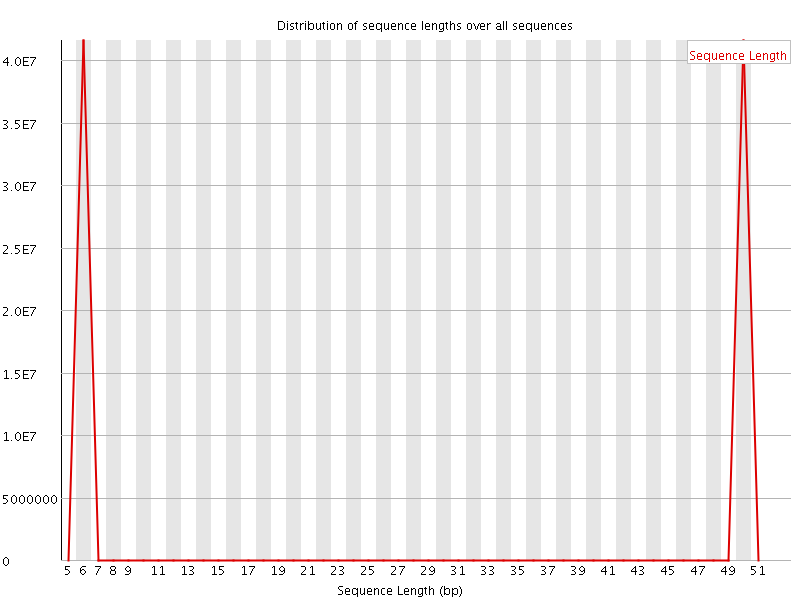

In [48]:
from IPython.display import Image
from IPython.core.display import HTML 
Image(url= "data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAAAyAAAAJYCAIAAAAVFBUnAABOh0lEQVR42u3dDbDOdf7/8ZOhVUpJWT9bS8la5efHIqWUUSnbRu1KRnMGqzYrozX+yojWKD9jmZK2zdYYUqtYJaGMUkrWT2ukG7Fxbp3LcX+THLeH//vNdpy9rutc1/fm8/l8v4fne3bM2cv3+zjH9+3t/eq6zTlBURRFURRFGa0cLgFFURRFURQBi6IoiqIoioBFURRFURRFwKIoiqIoiqIIWBRFURRFUQQsiqIoiqIoAhZFURRFURRFwKIoiqIoiiJgURRFURRFEbAoiqIoiqIoAhZFURRFURQBi6IoiqIoioBFURRFURRFwKIoiqIoiqIIWBRFURRFUQQsiqIoiqIoAhZFURRFURRFwKIoiqIoiiJgURRFURRFEbAoiqIoiqIoAhZFWR2h/6yk3woGhjk9zIle/qRnQL+qhWnjxzsD2kdRBCyKOosCVoBd6+UwX+vQ9u48Y3azqT9IZYeARVEUAYuirC/stPus8l1cSXd3Vb4x9fTU+8ZSv04Lpn7ftN+uqj9UEpjh+LTfIu39eVX9GcP82B6/u6nv4qWD3n+Sqrrm5S9AVXKGvzDVuoOZLyZFEbAo6mwMWBmOSV05SbEma24LcGPmjet3N/s9PUMW9Ptje/zuXuKvx+/i/U+UOQp4/IN7+Yvhnc3a7th2kFxFEbAoioB1ImQOqOosgwHLYwSxFLAs/VlMBayQl9FNwPL1N9N4wHLfQQIWRcCiKAJW9v/oP5MCVto/Wuqz/v3+WTILmddzVa85MPJdvAesAHc1peYqLxczwxXwnpLj30EeH6QIWBRFwMrx9VvVPWAFuJvE79INdv9HyJ8zfMDy+43SBiwvf+U8/vwe71SLcwfJWBQBi6LO0oDlcdd6DFhZ92V1DFhV3bkS/4CV9YKfJQErwg4SsCgCFkWdRQEr6/tgZf3dDLdneEXVCc/PR/aeBryclfnIE+kepTpRxWvQMvxZvDzAdCLja9A8BgXv3+WE/+d0e3+pZobAHfghQo9xLf4d5CWEFAGLoijKUyrlJ6eDFEXAoiiKOnvXc+a7xOggRVEELIqiKIqiKAIWRVEURVEUAYuiKIqiKIoiYFEURVEURRGwKIqiKIqiCFgURVEURVEELIqiKIqiKIqA5bP2PPtsyS237HnuOf4GUBRFURS7m4D1w8/t523utqRU/g03bMrJKejYMfW3fP0YW/wUMjIyMjJyPOVlVKAiYCVXwcmAJTGLMUNGRkZGRs6cFai0RcBKdw/W9dfrPVgELGRkZGRkZAIWActswJJfGTNkZGRkZGQCFgHLUMC67joNWB06MGbIyMjIyMgELAKWoYDVrp0GrPbtGTNkZGRkZGQCFgHLUMD6xS80YP3iF4wZMjIyMjIyAYuAZSZgFbRurQGrdWvGDBkZGRkZmYBFwDJ0D1bLlhqwWrVizJCRkZGRkQlYBCxDAeuaazRgXXMNY4aMjIyMjEzAImAZClg/+5kErLzmzRkzZGRkZGRkAhYBy0zAyrvySg1YV13FmCEjIyMjI1fOCrIfK/5XLSKB1Z8zA07AShewfvpTDVg//SljhoyMjIyMXJEVqkuoshqwKoMELJ8Bq2FDDVj/9V+MGTIyMjIyctaAlfY+rco3VvxWVekkVag4MQOb4btnzkABvl3lA5L+OGm/OwErXcC69FINWJdeypghIyMjIyMnPUTo5R6d1ADk/eAMZ3n87pkDVrBv5+uPRsBK/xdr04UX6iWrW5cxQ0ZGRkZGTsoKae/7yZyEggWsrKzZgBXmRgKWt4BVu7b+7aldmzFDRkZGRkZOmxWS7vtJ+9iZrzurMgiZA1bm5917PCUWAStzfMk5Wam3VK6qboxLwKpRQy96jRqMGTIyMjIyctaAlTXW+I1Nwe7BSlseT4k+YGUOQxW/VfkYL3EnPgErUVRUkWoTxcWMGTIyMjIyAStMwKrq6U3VKGBlva8rbMCquPPJS6xJG7YcpKuwAWvjRn2G+6mAtXEjY4aMjIyMTMBKfXCtqgfdUm+sKm+lPTjY6w0zP0SYFvf17fzem+UvYGUNTMECVo6FN9VYGKLemzVLr+Y558iv773++kKKoiiKOrsr/Du5V8c30Ar5R/AasLw85JchYGV4rpWNgBXqHqw1a/QerJNPw0p8/jn/HYOMjIyMzD1YZ2fACvO29T4CVtbnpAe4ByvHzhUPE7BKVq7UgFWzpvwqXzNmyMjIyMgErBOUpYDlJb6cIQFr2TINWOeeqwHr448ZM2RkZGRkAhYVoIwFrBM+X0WYY+0Ow1ABa8kSDVgn3wpLvmbMkJGRkZGRYy4b3N1uKnswSvucKi/vgxXbgLV5wQJtUp068qt8zTAgIyMjIyPHXDa4u6MMWPGvUAFr7lxtUt262qQ332QYkJGRkZGR4x6wzO1uApa1gHXybRryLrlEmzRrFsOAjIyMjIwc94BlbncTsKwFrOnTtUmXXaZNmjGDYUBGRkZGRo57wDK3uwlYtgJW8dSp0p78Ro3kV/maYUBGRkZGRo65bHB3E7CsBawpU7RJjRtrk6ZMYRiQkZGRkZHjHrDM7W4ClrWANXGiNunqq7VJkyYxDMjIyMjIyHEPWOZ2NwHLWsAaN06b1KKFNmncOIYBGRkZGRk57gHL3O4mYNkKWEWjR2uT/ud/5NeiJ59kGJCRkZGRkWMuG9zdBCxrAevxx6U9Be3ba5NGjGAYkJGRkZGR4x6wzO1uApa1gDV0qDbpppu0SUOHMgzIyMjIyMhxD1jmdjcBy1rAGjRIm3TrrfJr4aBBDAMyMjIyMnLcA5a53U3AshWwCgcM0Pb88pf664ABDAMyMjIyMnLMZYO7m4BlLWDl5mp7fv1r/TU3l2FARkZGRkaOe8Ayt7sJWNYCVq9e2p4+ffTX++9nGJCRkZGRkeMesMztbgKWrYBV0KOHPkXu5J2N8jXDgIyMjIyMHHPZ4O4mYFkLWHfeqU165BFtUrduDAMyMjIyMnLcA5a53U3AshawunTRJv2//6dN6tKFYUBGRkZGRo57wDK3uwlY1gLWqXfRePLJU++owTAgIyMjIyPHPWCZ290ELFsBK79dO/0kowkT9E3327dnGJCRkZGRkWMuG9zdBCxrAatVK2nP5ilTtEmtWjEMyMjIyMjIcQ9Y5nY3ActawGreXJs0bZo26ec/ZxiQkZGRkZHjHrDM7W4Clq2AldekibSnZPZs+TXvyisZBmRkZGRk5JjLBnc3ActawGrUSJu0aJE2qVEjhgEZGRkZGTnuAcvc7iZgWQtY9etrkz7+WJt06aUMAzIyMjIyctwDlrndTcCyFrAuvFDak1i9Wpt04YUMAzIyMjIyctwDlrndTcCyFbA2nXuutGfLt9/Kr/I1w4CMjIyMjBxz2eDuJmDZCViJhPbmnHP+/YV0i2FARkZGRkaOs2x0dxOw7ASswsKK8PvvOFxYyDAgIyMjIyPHVza6uwlYVgJWYsOGiodv//2A7r/+xTAgIyMjIyPHVja7uwlYdgLWl19WvADh1EsS5BaGARkZGRkZOb4By+juJmDZCVinXoBw8i00Tr2phtzCMCAjIyMjI8c3YBnd3QQsOwFrxYqKN4E99bawiX/8g2FARkZGRkaOb8AyursJWFYCVsmHH1Z8jNGpDzaSWxgGZGRkZGTk2MpmdzcBy07Aeu+9ig/iPvXR3CWLFzMMyMjIyMjI8Q1YRnc3ActOwJo/X5vUvr02qV07bdI77zAMyMjIyMjI8Q1YRnc3ActKwNo8Z440puCmm+Rr+VW+llsYBmRkZGRk5NjKZnc3ActOwHr1VW3Srbdqk7p00Sa99hrDgIyMjIyMHN+AZXR3E7DsBKxp07RJ3bppk+68U5s0bRrDgIyMjIyMHN+AZXR3E7DsBKwXX9Qm9eihTerRQ5v04osMAzIyMjIycnwDltHdTcCyErCKn31WGlN4//3ydWGvXvJ18eTJDAMyMjIyMnJsZbO7m4BlJ2BNmKBNys3VJuXmapMmTGAYkJGRkZGR4xuwjO5uApadgDV2rDZpwABt0oAB2qSnnmIYkJGRkZGR4xuwjO5uApadgDVqlDZp0CD5umjQIG3SqFEMAzIyMjIycnwDltHdTcCyErCKhg+XxhQNHapfDx2qXw8fzjAgIyMjIyPHVja7uwlYdgLWkCHamBEj9OvHH9evH32UYUBGRkZGRo5vwDK6uwlYdgLWwIHamCef1K9Hj9avBw5kGJCRkZGRkeMbsIzubgKWnYDVv78+djtunD6mO26cPqbbvz/DgIyMjIyMHN+AZXR3E7CsBKzCPn20SZMmaZMmTtQmPfAAw4CMjIyMjBxb2ezuJmDZCVg9e2qTpkzRJk2Zok3q2ZNhQEZGRkZGjm/AMrq7CVh2Atbdd2uT/vpXbdLUqdqk7t0ZBmRkZGRk5PgGLKO7m4BlJWAVdO2qn2E0Y4Z8vXn6dP1so65dGQZkZGRkZOTYymZ3NwHLTsDq3FmbNGuWNmnWLG1S584MAzIyMjIycnwDltHdTcCyE7BuuEGb9Oab2qS5c7VJHTsyDMjIyMjIyPENWEZ3NwHLTsBq21abtGCBNmnBAm1S27YMAzIyMjIycnwDltHd7Tpg5VSqDLEm7WE5KVXVjZEHrPxrr5XGlCxZIl/Lr/J1fsuWDAMyMjIyMnJsZbO7O8p7sKqKL35vDxyJLAasZs20SR9/rE1atkyb1KwZw4CMjIyMjBzfgGV0d59RActsugoVsBo31iatXKlNWrlSm9S4McOAjIyMjIwc34BldHdHFrC8PEToK+4YT1dSC4PWhksukcYsnjlTvl78yivy9Yb69RdSFEVRFBXXiu3u9hqwvD9TKumwzM+1shGwAt+DlVevnjQmsW6dfJ34+mv5Wm7hvzaQkZGRkZFjK5vd3XG8B6uqwzLf6WXl5w4csM4/X5u0caM2aeNGbVKdOgwDMjIyMjJyfAOW0d0dx+dgnQkBq2ZNbVJxsTapqEibVKsWw4CMjIyMjBzfgGV0d8c6YKU+ROgyXQUPWCUl0pVNNWpU3CBfyy1yO8OAjIyMjIwcR9n07nYdsKp6ElXa97tKjTtpn4YVu4CVl6dNOu+8002qXVublJ/PMCAjIyMjI8dRNr27o7wHK/4VMGCtX69Nuuii002qW1ebtH49w4CMjIyMjBxH2fTuJmCZD1iJtWv1gdsGDU7H4gYN9GHdtWsZBmRkZGRk5BjKxnc3ActCwFq1Spt0xRWnm3T55dqkzz5jGJCRkZGRkeMYsEzvbgKWhYC1fLk2qWnT001q2lSbtHw5w4CMjIyMjBzHgGV6dxOwLASsDz7QJrVocbpJLVpok5YuZRiQkZGRkZHjGLBM724ClvmAVbJokX6AUZs2Fbfkt26tH2+0aBHDgIyMjIyMHEPZ+O4mYFkIWPPmaZM6dDjdpA4dtEnz5jEMyMjIyMjIcQxYpnc3ActCwHrjDW3SzTefblKnTtqk2bMZBmRkZGRk5DgGLNO7m4BlPmBtPvkR3AW3315xS8Ftt8ktcjvDgIyMjIyMHEPZ+O4mYJkPWMUvvaRNuuuu00266y5t0ssvMwzIyMjIyMgxlI3vbgKWhXuw/vxnbdKvf326Sffeq0164QWGARkZGRkZOY73YJne3QQsCwHrmWe0Sb17n25S797apGeeYRiQkZGRkZHjGLBM724ClvmAVfS//ystKerXr+KWwr595Zbi8eMZBmRkZGRk5BjKxnc3ActCwBozRpv0u9+dbtJDD+ktY8YwDMjIyMjIyHEMWKZ3NwHLfMAqHjlSWlI4ePDpJg0erCl45EiGARkZGRkZOYay8d1NwLJwD9awYZp5hw3LcAvDgIyMjIyMHKN7sEzvbgKW+YCVmnlTczHDgIyMjIyMHB/Z+O4mYFkIWCmP2qY+ssswICMjIyMjxyhgmd7dBCwLASvldQenXpsgtzMMyMjIyMjIcQxYpnc3Act8wEp954zUd9dgGJCRkZGRkeMjG9/dBCwLASvlvV9T3x+WYUBGRkZGRo5RwDK9uwlYFgJWyqcXpX7CEcOAjIyMjIwco4BlencTsCwErJTP3079jG6GARkZGRkZOUYBy/TuJmCZD1j5nTpJS0pmz664peSNN+SW/JtvZhiQkZGRkZFjKBvf3QQsCwGrQwdt0rx5p5s0b542qUMHhgEZGRkZGTmOAcv07iZgWQhYrVtrk95993STFi3SJrVpwzAgIyMjIyPHMWCZ3t0ELPMBK69FC2lJYunSilsSH3wgt8jtDAMyMjIyMnIMZeO7m4BlIWA1bapNWr78dJOWL9cmNW3KMCAjIyMjI8cxYJne3QQsCwHr8su1SZ99drpJq1Zpk664gmFARkZGRkaOY8AyvbsJWBYCVoMG2qS1a083ae1abVKDBgwDMjIyMjJyHAOW6d1NwDIfsDbVrSst2bJ+/elur18vt2y66CKGARkZGRkZOYay8d1NwLIQsGrX1ibl559uUl6eNql2bYYBGRkZGRk5jgHL9O4mYFkIWDVqaJNKSk43qaREm1SjBsOAjIyMjIwcx4BlencTsAwHrERRkT5kW6tWUr/zatbUB3eLixkGZGRkZGTkWMk2djcBy3TA2rhRm1SnTnKTzj9fm7RxI8OAjIyMjIwcr4BlYXcTsEwHrK+/1ibVq5fcpHr1tEnr1jEMyMjIyMjI8QpYFnY3Act0wFqzRpvUsGFyk378Y23S558zDMjIyMjIyPEKWBZ2NwHLcMAqWblSP7qoceOkJskt+iFHK1cyDMjIyMjIyLGSbexuApbpgLVsmTbpZz9LblKzZtqkjz9mGJCRkZGRkeMVsCzsbgKW6YC1ZIk2qWXL5CZde602ackShgEZGRkZGTleAcvC7iZgGQ5YmxcskGYUtG2b1CS5RW6X32UYkJGRkZGRYyXb2N0ELNMBa+5cbVLHjslNuuEGbdKbbzIMyMjIyMjI8QpYFnY3Act0wJo1S5vUuXNykzp31ibNmsUwICMjIyMjxytgWdjdBCzTAWv6dG1S167JTeraVZs0YwbDgIyMjIyMHK+AZWF3E7AMB6ziqVOlGYXduyc1qfDuu+V2+V2GARkZGRkZOVayjd1NwDIdsKZM0Sb17JncpJ49tUlTpjAMyMjIyMjI8QpYFnY3Act0wJo4UZv0wAPJTerTR5s0aRLDgIyMjIyMHK+AZWF3E7BMB6xx47RJ/fsnNamof39t0rhxDAMyMjIyMnK8ApaF3U3AMhywikaPlmYUDRyY3KSBA/X2J59kGJCRkZGRkWMl29jdBCzTAevxx7UZjz6a3KQhQ/T2ESMYBmRkZGRk5HgFLAu7m4BlOmANHarNGD48uUnDh+vtQ4cyDMjIyMjIyPEKWBZ2NwHLdMAaNEibMWpUUpOKR43Sx3cHDWIYkJGRkZGR4xWwLOxuApbhgFU4YIA+Ie6pp5KbNHasNmnAAIYBGRkZGRk5VrKN3e06YOVUqqzhJumYnJSq6sYoA1ZurjZpwoTkJk2YoE3KzWUYkJGRkZGR4xWwLOzuKO/ByhBfKn6r8jFe4k70AatXL23S5MnJTXr2WW3S/fczDMjIyMjIyPEKWBZ2dxwDVuodVx7jjtl0FSxgFfTooZ9b9OKLSU2SW/Rzjnr0YBiQkZGRkZFjJdvY3ZEFLC93X/kKWMbTldRC//X59ddLMz5+4omk2+UWuf3zG25YSFEURVFUnCrmu9trwMr6TKkMASvDc61sBKwg92B16aIp+LXXklPwq69qCu7Shf/aQEZGRkZGjtc9WBZ29xlyD5aNdBUwYN10kzZpzpzkJs2Zo0266SaGARkZGRkZOV4By8LuPkOegxWfgJXfrp00o+Sdd5KaVDJ/vtye3749w4CMjIyMjBwr2cbujmPAOuHzVYSW0lXAgNWqlTZp8eLkJr33njapVSuGARkZGRkZOV4By8Ludh2wqnoSVdrnVHl5H6zYBazmzbVJH36Y3KQPP9Qm/fznDAMyMjIyMnK8ApaF3R3lPVjxrwABK69JE2lG4h//SGpSYsUKuT3vyisZBmRkZGRk5FjJNnY3Act0wGrUSJu0enVyk1av1iY1asQwICMjIyMjxytgWdjdBCzTAat+fW3SV18lN+nLL7VJl17KMCAjIyMjI8crYFnY3QQs0wHrwgu1Sf/6V3KTNmzQJl14IcOAjIyMjIwcr4BlYXcTsAwHrE3nnivN2FJYmNzwwkK5XX6XYUBGRkZGRo6VbGN3E7CMBqxEQjtxzjlpGn7qt6R/DAMyMjIyMnJ8ZDu7m4BlNGD9Z9RNqsoBmWFARkZGRkaOhWxndxOwTAaspAdrk6ryQ7wMAzIyMjIychxkS7ubgGU0YP3nyw2Sm3TqRQpffskwICMjIyMjxyVg2dndBCyjAes/3zAjuUmV3maDYUBGRkZGRo5FwLKzuwlYRgPWf77la3KTKr1RLMOAjIyMjIwci4BlZ3cTsEwGrKQPLUqqyh91xDAgIyMjIyPHQba0uwlYRgPWf37sdnKTKn1YN8OAjIyMjIwci4BlZ3cTsIwGrPnztUnt26dvUrt22qR33mEYkJGRkZGR4xKw7OxuApbJgLV5zhxpQ8FNN6VtktwuvyvHMAzIyMjIyMgxkS3tbgKW0YD16qvapFtvTd+kLl20Sa+9xjAgIyMjIyPHJWDZ2d0ELKMBa9o0bVK3bumbdOed2qRp0xgGZGRkZGTkuAQsO7ubgGU0YL34ojapR4/0TerRQ5v04osMAzIyMjIyclwClp3dTcAyGbCKn31W2lB4//1pm1TYq5f8bvHkyQwDMjIyMjJyTGRLu5uAZTRgTZigTcrNTd+k3Fxt0oQJDAMyMjIyMnJcApad3U3AMhqwxo7VJg0YkL5JAwZok556imFARkZGRkaOS8Cys7sJWEYD1qhR2qRBg9I2qWjQIG3SqFEMAzIyMjIyclwClp3dTcAyGbCKhg+XNhQNHZq+SUOH6u8OH84wICMjIyMjx0S2tLsJWEYD1pAh2oYRI9I36fHH9XcffZRhQEZGRkZGjkvAsrO7CVhGA9bAgdqGJ59M36TRo/V3Bw5kGJCRkZGRkeMSsOzsbgKW0YDVv78+UjtuXNomye36KG///gwDMjIyMjJyXAKWnd1NwDIZsAr79NEmTZqUvkkTJ2qTHniAYUBGRkZGRo6JbGl3E7CMBqyePbVJU6akb9KUKdqknj0ZBmRkZGRk5LgELDu7m4BlNGDdfbc26a9/Td+kqVO1Sd27MwzIyMjIyMhxCVh2djcBy2TAKujaVT+xaMaMtE3aPH26ftpR164MAzIyMjIyckxkS7ubgGU0YHXurE2aNSt9k2bN0iZ17swwICMjIyMjxyVg2dndBCyjAeuGG7RJb76Zvklz52qTOnZkGJCRkZGRkeMSsOzsbgKW0YDVtq02acGC9E1asECb1LYtw4CMjIyMjByXgGVndxOwTAas/GuvlTaULFmStklyu/xufsuWDAMyMjIyMnJMZEu7m4BlNGA1a6ZN+vjj9E1atkyb1KwZw4CMjIyMjByXgGVndxOwjAasxo21SStXpm/SypXapMaNGQZkZGRkZOS4BCw7u5uAZTJg5f34x9KGxOefp21SYs0a+d28hg0ZBmRkZGRk5JjIlnY3ActowKpXT5u0bl36Jn39tTapXj2GARkZGRkZOS4By87uJmAZDVjnn69N2rgxfZM2btQm1anDMCAjIyMjI8clYNnZ3QQsowGrZk1tUnFx+iYVFWmTatViGJCRkZGRkeMSsOzsbgKWuYBVUiI92FSjRoauy+/KMXIkw4CMjIyMjBy9bG13E7DMBay8PG3SeedlalLt2tqk/HyGARkZGRkZOXrZ2u4mYJkLWOvXa5MuuihTk+rW1SatX88wICMjIyMjRy9b290ELGMBK7F2rT5M26BBhibJ7+oDvWvXMgzIyMjIyMiRy/Z2NwHLXMBatUqbdMUVmZp0+eXapM8+YxiQkZGRkZGjD1jWdjcBy1zAWr5cm9S0aaYmNW2qTVq+nGFARkZGRkaOPmBZ290ELHMB64MPtEktWmRqUosW2qSlSxkGZGRkZGTk6AOWtd1NwDIWsEoWLdKPK2rTJkOT8lu31g88WrSIYUBGRkZGRo5ctre7CVjmAta8edqkDh0yNalDB23SvHkMAzIyMjIycvQBy9ruJmCZC1hvvKFNuvnmTE3q1EmbNHs2w4CMjIyMjBx9wLK2uwlYxgLW5ldekQYU3H57hiYV3HabHCNHMgzIyMjIyMiRy/Z2NwHLWMAqfuklbdJdd2Vq0l13aZNefplhQEZGRkZGjly2t7sJWObuwfrzn7VJv/51pibde6826YUXGAZkZGRkZOTo78GytrsJWOYC1jPPaJN6987UpN69tUnPPMMwICMjIyMjRx+wrO1u1wErp1JliDVpD8tJqapujCRgFf3v/0oDivr1y9Ckwr595Zji8eMZBmRkZGRk5Mhle7s7ynuwqoovfm8PHIkMB6wxY7RJv/tdpiY99JAeM2YMw4CMjIyMjBx9wLK2u8+ogGU2XfkFi0eOlAYUDh6cqUmDB2sKHjmSYUBGRkZGRo5ctre7Yxqw0j7YlznuGE9XUgv91P/16SMNkF9DHkNRFEVRlJuqFrvbX8AK8Hhf5uda2QhYvsyKhJshBVckZf5rAxkZGRkZOXLZ3u6O5h4s78El6UnuLu++8h2wfniMNkOTKh7rZRiQkZGRkZGjD1jWdncEActXaqlOAeuHVxlkatLJVyvIkQwDMjIyMjJy9AHL2u52HbACp6sT4V5d6CBgVbxPRoYmVbzfBsOAjIyMjIwcuWxvd0cQsKp6j6vUY1LjTtrT4xKwfnin10xN+uEdYxkGZGRkZGTk6AOWtd0dwUOE1aj8BawfPqso0xPlfvjMI4YBGRkZGRk5+oBlbXcTsMwFrB8+bTtTCv7hU7sZBmRkZGRk5OgDlrXdTcAyFrDyO3WSBpTMnp2hSSVvvCHH5N98M8OAjIyMjIwcuWxvdxOwzAWsDh20SfPmZWrSvHnapA4dGAZkZGRkZOToA5a13U3AMhewWrfWJr37bqYmLVqkTWrThmFARkZGRkaOPmBZ290ELGMBK69FC2lAYunSDE1KfPCBHCNHMgzIyMjIyMiRy/Z2NwHLXMBq2lSbtHx5piYtX65NatqUYUBGRkZGRo4+YFnb3QQscwHr8su1SZ99lqlJq1Zpk664gmFARkZGRkaOPmBZ290ELHMBq0EDbdLatZmatHatNqlBA4YBGRkZGRk5+oBlbXcTsIwFrE1160oDtqxfn6nt69fLMZsuuohhQEZGRkZGjly2t7sJWOYCVu3a2qT8/ExNysvTJtWuzTAgIyMjIyNHH7Cs7W4ClrmAVaOGNqmkJFOTSkq0STVqMAzIyMjIyMjRByxru5uAZSZgHT9yRB+grVUra+PzataUI48fPcowICMjIyMjRyhb3d0ELDMBq3z/fm1SnTrZm3T++XKkHM8wICMjIyMjRyhb3d0ELDMB69iOHdqkevWyN6lePTny2M6dDAMyMjIyMnKEstXdTcAyE7COnnyANq9hw+xN+vGP5cijiQTDgIyMjIyMHKFsdXcTsMwErCMnX2KQ37hx1ibJMXKkHM8wICMjIyMjRyhb3d0ELDMB6/C6ddqkn/0se5OaNZMjD3/zDcOAjIyMjIwcoWx1dxOwzASsQ2vWaJNatszepGuvlSPleIYBGRkZGRk5Qtnq7iZgmQlYB1eulEtf0LZt1ibJMXKkHM8wICMjIyMjRyhb3d0ELDMBq+yjj7RJHTtmb9INN8iRZcuWMQzIyMjIyMgRylZ3NwHLTMA6sHixNqlz5+xN6txZjpTjGQZkZGRkZOQIZau7m4BlJmB9//bb2qSuXbM3qWtXOfL7+fMZBmRkZGRk5Ahlq7ubgGUmYO2fPVsufWH37lmbVHj33XKkHM8wICMjIyMjRyhb3d0ELDMB67uZM7VJPXtmb1LPnnKkHM8wICMjIyMjRyhb3d0ELDMBa99LL2mTHngge5P69JEj9738MsOAjIyMjIwcoWx1dxOwzASsvc8/r03q3z9rk4r695cj5XiGARkZGRkZOULZ6u4mYJkJWHsmTpRLXzRwYPYmDRwoR+6ZNIlhQEZGRkZGjlC2ursJWGYC1u6nn9YmPfpo9iYNGSJH7h43jmFARkZGRkaOULa6uwlYZgLWrtGjtUnDh2dv0vDhcqQczzAgIyMjIyNHKFvd3QQsMwFr58lLXzRqVNYmFY8aJUfufOwxhgEZGRkZGTlC2eruJmCZCVg7Tt55WPzUU9mbNHasHCnHMwzIyMjIyMgRylZ3NwHLTMDa/vDD2qQJE7I3acIEOVKOZxiQkZGRkZEjlK3ubgKWmYC1rW9fbdLkydmb9OyzcuS2fv0YBmRkZGRk5Ahlq7ubgGUmYG3t3Vsu/eYXX8zaJDlGjpTjGQZkZGRkZOQIZau7m4BlJmCV3nOPNmnatOxNmjZNjiy9916GARkZGRkZOULZ6u4mYJkJWFu6ddMmvfZa9ia9+qocKcczDMjIyMjIyBHKVnc3ActMwEp06aJNmjMne5PmzJEj5XiGARkZGRkZOULZ6u4mYJkJWCUdO8qlL3nnnaxNKpk/X4+88UaGARkZGRkZOULZ6u4mYJkJWJvbttVLv3hx9ia9957m5bZtGQZkZGRkZOQIZau7m4BlJmAVX3utNunDD7M36cMP9UWhLVsyDMjIyMjIyBHKVnc3ActMwCq6+mp9dPYf/8japMSKFfrG/M2aMQzIyMjIyMgRylZ3NwHLTMAqvOIKbdLq1dmbtHq1HCnHMwzIyMjIyMgRylZ3NwHLTMAquOwybdJXX2Vv0pdfypEFDRowDMjIyMjIyBHKVnc3ActMwMqvW1eb9K9/ZW/Shg1ypBzPMCAjIyMjI0coW93dBCwzASvvRz/StyArLMze+cJCOVKOZxiQkZGRkZEjlK3ubgKWiYB1/Lhc903nnOOp84mEHpyTwzAgIyMjIyNHJlve3QQsAwHr+KFDet3PPddj7+VIOV7OYhiQkZGRkZEjkW3vbgKWgYBVvnev3nN44YUemyRHyvHl+/YxDMjIyMjIyJHItnc3ActAwDq2bZs26dJLvTapfn05Xs5iGJCRkZGRkSORbe9uApaBgHW0uFib1KiR1yY1aiTHy1kMAzIyMjIyciSy7d1NwDIQsI58+6026corvTapSRM5/sjGjQwDMjIyMjJyJLLt3U3AMhCwDn/1lb49xs9/7rFJ+c2by/FyFsOAjIyMjIwciWx7d7sOWDmVKmu4STomJ6WqutFxwDr0z39qk1q18tqkVq3k+EOrVzMMyMjIyMjIkci2d3eU92BliC8Vv1X5GC9xJ5KAdfDTT7VJ7dt7bVK7dnL8wRUrGAZkZGRkZORIZNu7O44BK/WOK49xJ8f0O4B5BMuWLtWPKLrpJo9NkiPleDmLYUBGRkZGRo5Etr27z5yAlWPh/VUXeqtlY8bIRV/brp3H4784mYI/GjNmIUVRFEVRUVQ12t3+ApaXxwdTA1aG51rZCFgeze/fektTcLduXlPwnXfK8XIW/7WBjIyMjIwciWx7d0dzD5av+6K83IOVY+fjgTyy+19/XZvUo4fXJvXoIcfLWQwDMjIyMjJyJLLt3R1BwPL7VKr4B6zvpk+Xi154//0em1TYq5cc/92MGQwDMjIyMjJyJLLt3e06YHmMLL5eRZhj7dOtPcr7pk7VJuXmem1Sbq4cL2cxDMjIyMjIyJHItnd3BAEr7fOo0j6nysv7YMUhYO2dPFmbNGCA1yYNGCDH733uOYYBGRkZGRk5Etn27o7gIcJqVB4D1p4JE7RJgwZ5bFLRoEFyvJzFMCAjIyMjI0ci297dBCwDAWv32LFy0YuGDvXapKFD5Xg5i2FARkZGRkaORLa9uwlYBgLWrpEjtUkjRnht0uOPy/G7nniCYUBGRkZGRo5Etr27CVgGAtbOYcO0SU8+6bVJo0fL8XIWw4CMjIyMjByJbHt3E7AMBKwdjzwiF7143DiPTZIj5fgdgwczDMjIyMjIyJHItnc3ActAwNr+4IPapEmTvDZp4kQ5fvtDDzEMyMjIyMjIkci2dzcBy0DA2nbyvTGKp0zx2qQpU+R4OYthQEZGRkZGjkS2vbsJWAYC1tb77tMm/fWvXpt08s3NtvbqxTAgIyMjIyNHItve3QQsAwGrtHt3ueibZ8zw2KTNJ9+eX85iGJCRkZGRkSORbe9uApaBgLXljju0SbNmeW3SrFlyvJzFMCAjIyMjI0ci297dBCwDAStxyy3apDff9NqkuXPl+ETnzgwDMjIyMjJyJLLt3U3AMhCwSq6/Xpu0YIHXJi1YIMfLWQwDMjIyMjJyJLLt3U3AMhCwNrdurRd9yRKPTZIjtalt2jAMyMjIyMjIkci2dzcBy0DAKm7RQpv08cdem7Rsmb5yoUULhgEZGRkZGTkS2fbuJmAZCFhFV12lTVq50muTVq7Ut+e/6iqGARkZGRkZORLZ9u4mYBkIWIWNGukT3z7/3GOTEmvWyPGFP/kJw4CMjIyMjByJbHt3E7AMBKyC+vW1SevWeW3S11/L8XIWw4CMjIyMjByJbHt3E7AMBKz8OnW0SRs3em3Sxo1yfP4FFzAMyMjIyMjIkci2dzcBy0DAyqtZU5tUXOy1SUVFcnxerVoMAzIyMjIyciSy7d1NwAodsMrL5YpvqlHDV/vleDlLzmUYkJGRkZGRXcv2dzcBK2zAOn7ggEba88/31aS8886Ts46XlTEMyMjIyMjIjmUHu5uAFTZgle/erQ/K1qvnq0n5F18sZ8m5DAMyMjIyMrJj2cHuJmCFDVjHSkv1ZQUNG/pqkhwvZ8m5DAMyMjIyMrJj2cHuJmCFDVhHCwr0jTGaNPHVpMLGjeWso4WFDAMyMjIyMrJj2cHuJmCFDVhHNmzQt3Zt3txXk+R4OUvOZRiQkZGRkZEdyw52NwErbMA6vHatfjhRq1a+miTHy1mHv/iCYUBGRkZGRnYsO9jdBKywAevQqlX68drXXeerSZvbt5ez5FyGARkZGRkZ2bHsYHcTsMIGrIOffKKfFtmpk68myfFylpzLMCAjIyMjIzuWHexuAlbYgFW2ZIm+Feztt/tqUuK22+SssvffZxiQkZGRkZEdyw52NwErbMA6sGCBXO4tv/qVryZtuesuOUvOZRiQkZGRkZEdyw52NwErbMDa//e/y+Uu/c1vfPVIjpezvp87l2FARkZGRkZ2LDvY3QSs0AHrtdfkcm994AFfTdrap4+ctf9vf2MYkJGRkZGRXQcs+7ubgBU2YH03bZpc7m2//a2vJsnxcpacyzAgIyMjIyM7lh3sbgJW2IC194UX5HLvGDTIV5O2//73cta+v/yFYUBGRkZGRnYsO9jdBKywAWvPM8/I5d45dKivJu34wx/kLDmXYUBGRkZGRnYsO9jdBKzQAWv8eG3SiBG+miTHa5PGj2cYkJGRkZGRXQcs+7ubgBU2YO364x/lcu8eM8ZXkyrOYhiQkZGRkZEdyw52NwErbMCqyLO+mlSRnRkGZGRkZGRkx7KD3U3AChuwKh6R9dekHx79ZRiQkZGRkZEdyw52NwErbMCqeE2Bryadev2CnMswICMjIyMjO5Yd7G4CVtiAVfGuGL6aVPEOHAwDMjIyMjKyY9nB7iZghQ1YFe/r6qtJFe8hyzAgIyMjIyM7lh3sbgJW2IBV8clE/pr0w6cgMQzIyMjIyMiOZQe7m4AVNmBVfLa2ryZVfI43w4CMjIyMjOxYdrC7CVhhA1bittvkcpe9/76vJpUtWSJnJW6/nWFARkZGRkZ2LDvY3QSssAGrpFMnudwHP/nEV5PkeDlLzmUYkJGRkZGRHcsOdjcBK2zA2ty+vVzuQ5995qtJh1atkrM2X3cdw4CMjIyMjOxYdrC7CVhhA1Zxq1ZyuQ9/8YWvJh1eu1bOknMZBmRkZGRkZMeyg91NwAobsIqaN5fLfWTDBl9NkuPlLDmXYUBGRkZGRnYsO9jdBKywAauwcWO53EcLC3016WhBgZxV2KQJw4CMjIyMjOxYdrC7CVhhA1ZBw4ZyuY+VlvpqkhwvZ8m5DAMyMjIyMrJj2cHuJmCFDVj5F18sl7t8925fTZLj5az8evUYBmRkZGRkZMeyg91NwAobsPLOO08u9/GyMl9NOn7ggJwl5zIMyMjIyMjIjmUHu5uAFTZgbapRQy73ifJyf+0vL5ez5FyGARkZGRkZ2bHsYHdHE7ByTlaGWFO5qrr91G+lvdFZwDp+5IiG2Vq1ArQ/r2ZNjc9HjzIMyMjIyMjIzmQ3uzuCgFURjPzGGi/hyXHAKt+/Xx+OveCCAE3Kr1NHHwDev59hQEZGRkZGdia72d2RPURoI2CZTVdewGM7dugLCurXD9AkOUtfwrBzJ8OAjIyMjIzsTHazu2MasNI+2Jc57hhPV1ILs9XiV16RC72hfv2F/mvDJZfIuYtnzlxIURRFUZSrqna721jAquqYzM+1shGwsppH8vL0TV2vuipACpaz9G1k8/L4rw1kZGRkZGRnspvdHcd7sKo6LMCjirYD1uF16/Rjia65JkCTilu00A9C+uYbhgEZGRkZGdmZ7GZ3E7BCBaxDa9boB2u3aROgSZtbt9aP8l6zhmFARkZGRkZ2JrvZ3bEOWKkPEbpMV17kgytXyoUuuf76AE2Ss+RcERgGZGRkZGRkZ7Kb3R1BwEr7VKq073eVGneynus4YJV99JFc6ETnzgGalLjlFjm3bNkyhgEZGRkZGdmZ7GZ3R3YPVrWorAHrwOLFcqG33HFHgCbJWXKuCAwDMjIyMjKyM9nN7iZghQpY37/9tlzo0u7dAzRJzpJzv58/n2FARkZGRkZ2JrvZ3QSsUAFr/+zZcqG39uoVoElb77tPzhWBYUBGRkZGRnYmu9ndBKxQAeu7mTPlQm/LzQ3QJDlLzhWBYUBGRkZGRnYmu9ndBKxQAWvfSy/Jhd7+0EMBmrT9wQfl3H0vv8wwICMjIyMjO5Pd7G4CVqiAtff55+VC7xg8OECTdjzyiJwrAsOAjIyMjIzsTHazuwlYoQLWnokT5ULvHDYsQJPkLDl3z6RJDAMyMjIyMrIz2c3uJmCFCli7n35aLvSuJ54I0KRdI0fKubvHjWMYkJGRkZGRncludjcBK1TA2jV6tF7osWMDNEnO0gaPHs0wICMjIyMjO5Pd7G4CVqiAtXP4cL2r8E9/CtCkPRMm6F2Ujz3GMCAjIyMjIzuT3exuAlaogLVjyBB9sttzzwVo0t7Jk/VJdkOGMAzIyMjIyMjOZDe7m4AVKmBtf/hhfbnm1KkBmiRn6ctEH36YYUBGRkZGRnYmu9ndBKxQAWtb3776hmMzZgRo0nfTp+sbnfXrxzAgIyMjIyM7k93sbgJWqIC1tXdvfcv8118P0CQ5S9+qv3dvhgEZGRkZGdmZ7GZ3E7BCBazSe+7RD318660ATZKz9MMm772XYUBGRkZGRnYmu9ndBKxQAWtLt25yoQ+8+26AJh1YtEjOFYFhQEZGRkZGdia72d0ErFABK9Gli1zosqVLAzRJzpJzRWAYkJGRkZGRncludjcBK1TAKunYUS70wRUrAjTp4KefyrklN97IMCAjIyMjIzuT3exuAlaogLW5bVu50IdWrw7QpEP//KecKwLDgIyMjIyM7Ex2s7sJWKECVvG118qFPvzVVwGaJGfJucUtWzIMyMjIyMjIzmQ3u5uAFSpgFV19tVzoIxs3BmjSkW+/lXOLmjVjGJCRkZGRkZ3JbnY3AStUwCq84gq50EeLiwM0Sc6Sc0VgGJCRkZGRkZ3JbnY3AStUwCq47DK50Me2bw/QpGPbtsm5BQ0aMAzIyMjIyMjOZDe7m4AVKmDl160rF7p8374ATSrfu1fOFYFhQEZGRkZGdia72d0ErFABK+9HP5ILffzQoQBNkrPkXBEYBmRkZGRkZGeym91NwAoRsI4fl6u86ZxzArb/1Ok5OQwDMjIyMjKyI9nV7iZgBQ9YSTE2QPsrh2iGARkZGRkZ2bbsbHcTsIIHrKQHYgM0qfLDwAwDMjIyMjKybdnZ7iZgBQ9YSS8lCNCkf7+QYds2hgEZGRkZGdmB7Gx3E7CCB6ykN8MI0KTKb8XBMCAjIyMjI9uWne1uAlbwgJX0dq4BmlT5zWQZBmRkZGRkZNuys91NwAoesJI+kChAkyp/HBLDgIyMjIyMbFt2trsJWMEDVtJHagdoUuUP9GYYkJGRkZGRbcvOdjcBK3jAOvjpp3KJS268MXCTSjp2FOHgihUMAzIyMjIysgPZ2e4mYAUPWGVLl8olTnTpErhJcq4I4jAMyMjIyMjIDmRnu5uAFTxgHVi0SC7xll/+MnCTtnTrJsKBd99lGJCRkZGRkR3IznY3ASt4wPr+rbfkEpfee2/gJpXec48I4jAMyMjIyMjIDmRnu5uAFTxg7X/9dbnEW3v3DtwkOVcEcRgGZGRkZGRkB7Kz3U3ACh6wvps+XS7xtn79AjdpW9++Inw3YwbDgIyMjIyM7EB2trsJWMED1r6pU+USb3/44cBNknNFEIdhQEZGRkZGdiA7290ErOABa+/kyXKJdwwZErhJcq4Ie597jmFARkZGRkZ2IDvb3QSs4AFrz4QJcol3PvZY4CbtHD5cBHEYBmRkZGRkZAeys91NwAoesHaPHSuXeNfo0YGbJOeKIA7DgIyMjIyM7EB2trsJWMED1q6RI/USjxsXuEm7n35a2/zEEwwDMjIyMjKyA9nZ7iZgBQ9YO4cN0zsJJ00K3KQ9EyfqHZXDhjEMyMjIyMjIDmRnu5uAFTxg7XjkEX2a2/PPB26SnKtPtRs8mGFARkZGRkZ2IDvb3QSs4AFr+4MP6gs1X345cJP2vfSSvlj0oYcYBmRkZGRkZAeys91NwAoesLbl5upbjc2cGbhJcq6+3VluLsOAjIyMjIzsQHa2uwlYwQPW1vvu0zfLnzMncJP2z56tb9jfqxfDgIyMjIyM7EB2trsJWMEDVmn37vpxj/PnB27S92+/rR852b07w4CMjIyMjOxAdra7CVjBA9aWO+6QS3xg8eLATZJzRRCHYUBGRkZGRnYgO9vdBKzgAStxyy1yicuWLQvcpLKPPhIh0bkzw4CMjIyMjOxAdra7CVjBA1bJ9dfLJT64cmXgJsm5IojDMCAjIyMjIzuQne3uaAJWzsnKGm6SjslJqapudBOwNrduLZf40Jo1gZsk54qwuU0bhgEZGRkZGdmB7Gx3RxCwKoKRl2RT+TAv4cllwCpu0UIu8eFvvgncpMPr1okgDsOAjIyMjIzsQHa2uyN7iDBDdkm948pjeDKbrrKCRVddJZf4SF5e4CbJuSKIwzAgIyMjIyM7kJ3t7jMnYBlPV1ILM9aGSy6RS7x45syFQWvxK6+IsKF+/YUURVEURdmv6ri7XQSsDM+1shGwMpsF9evLJT62c2fgFHxsxw4RxOG/NpCRkZGRkR3Iznb3GXIPlo10lZXNr1NHLnH5/v2BmyTnipB/wQUMAzIyMjIysgPZ2e4mYAUPWHk1a8olPn70aOAmHT9yRIS8WrUYBmRkZGRkZAeys90dx4B1wuerCC2lqyxyeblc3001aoRsvwjiiMYwICMjIyMj25Ud7u4IAlbap1KlfU6Vl/fBiipgHT9wQAPs+eeHbFLeeedplC4rYxiQkZGRkZGtyi53d2T3YFWLyhCwynfv1odg69UL2aT8iy/WB4N372YYkJGRkZGRrcoudzcBK2DAOlZaqi8iaNgwZJNE0JczlJYyDMjIyMjIyFZll7ubgBUwYB0tKJCLW9ikScgmFTZuLM7RwkKGARkZGRkZ2arscncTsAIGrCMbNugbuTZvHrJJIuhbym7YwDAgIyMjIyNblV3ubgJWwIB1eO1a/SiiVq1CNkkE/VCkL75gGJCRkZGRka3KLnc3AStgwDq0apV+mPZ114Vs0ub27fVjvVetYhiQkZGRkZGtyi53NwErYMA6+MkncnFLOnUK2SQRxBGNYUBGRkZGRrYqu9zdBKyAAatsyRK5uInbbw/ZpMRtt4lT9v77DAMyMjIyMrJV2eXuJmAFDFgHFiyQi7vlV78K2aQtd90ljmgMAzIyMjIyslXZ5e4mYAUMWPv//ne5uKW/+U3IJokgzvdz5zIMyMjIyMjIVmWXu5uAFTRgvfaaXNytDzwQsklb+/QRZ//f/sYwICMjIyMj2w1YDnc3AStgwPpu2jS5uNt++9uQTRJBHNEYBmRkZGRkZKuyy91NwAoYsPa+8IJc3B2DBoVs0vbf/16cfX/5C8OAjIyMjIxsVXa5uwlYAQPWnmeekYu7c+jQkE3a8Yc/iCMaw4CMjIyMjGxVdrm7CVhBA9b48dqkESNCNkkEbdL48QwDMjIyMjKy3YDlcHcTsAIGrF1//KNc3N1jxoRsUqrDMCAjIyMjI9uQXe5uAlbAgJWaXoM1KTVNMwzIyMjIyMg2ZJe7m4AVMGClPv4asEkpjwczDMjIyMjIyDZkl7ubgBUwYKW+giBYk069okE0hgEZGRkZGdmq7HJ3E7ACBqzU98AI1qTU9+RgGJCRkZGRkW3ILnc3AStgwEp9F9dgTUp9V1mGARkZGRkZ2YbscncTsAIGrNTPIQrYpJTPRWIYkJGRkZGRbcgudzcBK2DASv0k7WBNSv1kb4YBGRkZGRnZhuxydxOwAgasxG23ycUte//9kE0qW7JEnMTttzMMyMjIyMjIVmWXu5uAFTBglXTqJBf34CefhGySCOKIxjAgIyMjIyNblV3ubgJWwIC1uX17ubiHPvssZJMOrVolzubrrmMYkJGRkZGRrcoudzcBK2DAKm7VSi7u4S++CNmkw2vXiiMaw4CMjIyMjGxVdrm7CVgBA1ZR8+ZycY9s2BCySSKIIxrDgIyMjIyMbFV2ubsJWAEDVmHjxnJxjxYWhmzS0YICcQqbNGEYkJGRkZGRrcoudzcBK2DAKmjYUC7usdLSkE0SQRzRGAZkZGRkZGSrssvdTcAKGLDyL75YLm757t0hmySCOPn16jEMyMjIyMjIVmWXu5uAFTBg5Z13nlzc42VlIZt0/MABcURjGJCRkZGRka3KLnc3AStgwNpUo4Zc3BPl5WHbX14ujmgMAzIyMjIyslXZ5e4mYAUJWMePHNHoWquWkfbn1aypgfroUYYBGRkZGRnZkux4dxOwggSs8v379cHXCy4w0qT8OnX0IeH9+xkGZGRkZGRkS7Lj3U3AChKwju3YoS8fqF/fSJPE0Rc17NzJMCAjIyMjI1uSHe9uAlaQgHW0pETfAOMnPzHSpMJGjfRtORIJhgEZGRkZGdmS7Hh3E7CCBKwjeXn6Fq5XXWWkSeLoG8vm5TEMyMjIyMjIlmTHu5uAFSRgHV63Tj+E6JprjDSpuEUL/Wikb75hGJCRkZGRkS3Jjnc3AStIwDq0Zo1+jHabNkaatLl1a/1w7zVrGAZkZGRkZGRLsuPdTcAKErAOrlwpl7Xk+uuNNEkc0cRkGJCRkZGRkS3Jjnc3AStIwCr76CO5rInOnY00KXHLLaKVLVvGMCAjIyMjI1uSHe9uAlaQgHVg8WK5rFvuuMNIk8QRTUyGARkZGRkZ2ZLseHcTsIIErO/fflsua2n37kaaJI5o38+fzzAgIyMjIyNbkh3vbgJWkIC1f/Zsuaxbe/Uy0qSt990nmpgMAzIyMjIysiXZ8e4mYAUJWN/NnCmXdVturpEmiSOamAwDMjIyMjKyJdnx7iZgBQlY+156SS7r9oceMtKk7Q8+KNq+l19mGJCRkZGRkS3Jjnc3AStIwNr7/PNyWXcMHmykSTseeUQ0MRkGZGRkZGRkS7Lj3U3AChKw9kycKJd157BhRpokjmh7Jk1iGJCRkZGRkS3Jjnc3AStIwNr99NNyWXc98YSRJu0aOVK03ePGMQzIyMjIyMiWZMe7m4AVJGDtGj1aL+vYsUaaJI62fPRohgEZGRkZGdmS7Hh3E7CCBKydw4frHYN/+pORJu2ZMEHvtHzsMYYBGRkZGRnZkux4dxOwggSsHUOG6FPbnnvOSJP2Tp6sT7sbMoRhQEZGRkZGtiQ73t0ErCABa/vDD+uLM6dONdIkcfSFow8/zDAgIyMjIyNbkh3vbtcBK+c/KzXQpM00Ed6e9s+zrW9ffXuxGTOMNOm76dP1rc/69WMYkJGRkZGRLcmOd3cEASvr3UVJx0R1e4afdmvv3voG+a+/bqRJ4uib9/fuzTAgIyMjIyNbkh3v7rgErJiEqsz/t6JK77lHP+LxrbeMNEkc/fjJe+9lGJCRkZGRkS3Jjnd3ZA8RVouAtbCK+qJdO7msH40Zs9BELRszRjQxF1IURVEUZaeq7+72FLA83lcU83uwEl26yGUtW7rUSAoWRzQx+a8NZGRkZGRkS7Lj3e36Hqyq4kv1ClglHTvKZT24YoWRJh389FPRSm68kWFARkZGRka2JDve3QSsIAFrc9u2clkPrV5tpEmH/vlP0cRkGJCRkZGRkS3Jjnd3ZAErw9Ow4v8qwuJrr5XLevirr4w0SRzRilu2ZBiQkZGRkZEtyY53t+uAVdWT3Cv/bqxuT/tzFl19tVzWIxs3GmnSkW+/Fa2oWTOGARkZGRkZ2ZLseHdH+RBh/KuqgFV4xRVyWY8WFxtpkjiiickwICMjIyMjW5Id724CVpCAVXDZZXJZj23fbqRJx7ZtE62gQQOGARkZGRkZ2ZLseHcTsIIErPy6deWylu/bZ6RJ5Xv3iiYmw4CMjIyMjGxJdry7CVhBAlbej34kl/X4oUNGmiSOaGIyDMjIyMjIyJZkx7ubgOU/YB0/Ltd00znnGGv/KbDqT2lkzJCRkZGRkUPJznc3Act3wKoqtIZpf9pYzZghIyMjIyMbkd3vbgKW74BV1cOuYZqU9oFhxgwZGRkZGdmI7H53E7B8B6yqXjgQpkn/fmnDtm0MAzIyMjIysnHZ/e4mYPkOWFW99UWYJqV9cw7GDBkZGRkZ2YjsfncTsHwHrKrevDVMk9K+vSxjhoyMjIyMbER2v7sJWL4DVlUfPxSmSWk/IIkxQ0ZGRkZGNiK7390ELN8Bq6oP0A7TpLQf8c2YISMjIyMjG5Hd724Clu+AdfDTT+WCltx4o8EmlXTsKObBFSsYBmRkZGRkZOOy+91NwPIdsMqWLpULmujSxWCTRBNTZIYBGRkZGRnZuOx+dxOwfAesA4sWyQXd8stfGmzSlm7dxDzw7rsMAzIyMjIysnHZ/e4mYPkOWN+/9ZZc0NJ77zXYpNJ77hFTZIYBGRkZGRnZuOx+dxOwfAes/a+/Lhd0a+/eBpskmpgiMwzIyMjIyMjGZfe7m4DlO2B9N326XNBt/foZbNK2vn3F/G7GDIYBGRkZGRnZuOx+dxOwfAesfVOnygXd/vDDBpskmpgiMwzIyMjIyMjGZfe7m4DlO2DtnTxZLuiOIUMMNkk0Mfc+9xzDgIyMjIyMbFx2v7sJWL4D1p4JE+SC7nzsMYNN2jl8uJgiMwzIyMjIyMjGZfe7m4DlO2DtHjtWLuiu0aMNNkk0MUVmGJCRkZGRkY3L7nc3Act3wNo1cqRe0HHjDDZp99NPa+OfeIJhQEZGRkZGNi67390ELN8Ba+ewYXqX4KRJBpu0Z+JEvety2DCGARkZGRkZ2bjsfncTsHwHrB2PPKJPanv+eYNNEk2ffDd4MMOAjIyMjIxsXHa/uwlYvgPW9gcf1JdlvvyywSbte+klffnoQw8xDMjIyMjIyMZl97ubgOU7YG3LzdU3Fps502CTRNM3QMvNZRiQkZGRkZGNy+53NwHLd8Daet99+tb4c+YYbNL+2bP1Lfx79WIYkJGRkZGRjcvudzcBy3fAKu3eXT/ccf58g036/u239UMou3dnGJCRkZGRkY3L7nc3Act3wNpyxx1yQQ8sXmywSaKJKTLDgIyMjIyMbFx2v7sJWL4DVuKWW+SCli1bZrBJZR99JGaic2eGARkZGRkZ2bjsfncTsHwHrJLrr5cLenDlSoNNEk1MkRkGZGRkZGRk47L73U3A8h2wNrduLRf00Jo1Bpskmpib27RhGJCRkZGRkY3L7nc3Act3wCpu0UIu6OFvvjHYpMPr1okpMsOAjIyMjIxsXHa/uwlYvgNW0VVXyQU9kpdnsEmiiSkyw4CMjIyMjGxcdr+7CVi+A1Zho0ZyQY8mEgabdLSkRMzCn/yEYUBGRkZGRjYuu9/dBCzfAaugfn25oMd27jTYpGM7dogpMsOAjIyMjIxsXHa/uwlYvgNWfp06ckHL9+832CTRxMy/4AKGARkZGRkZ2bjsfncTsHwHrLyaNeWCHj961GCTjh85ImZerVoMAzIyMjIysnHZ/e4mYPkMWOXlcjU31ahhvP1iiiw+w4CMjIyMjGxSjmJ3E7D8BazjBw5oXD3/fONNyjvvPA3XZWUMAzIyMjIyskE5kt1NwPIXsMp379YHXOvVM96k/Isv1oeHd+9mGJCRkZGRkQ3KkexuApa/gHWstFRfMtCwofEmiakvcCgtZRiQkZGRkZENypHsbgKWv4B1tKBA3/SiSRPjTSps3FjfoqOwkGFARkZGRkY2KEeyuwlY/gLWkQ0b9G1bmzc33iQx9U1mN2xgGJCRkZGRkQ3KkexuApa/gHV47Vr94KFWrYw3SUz9mKQvvmAYkJGRkZGRDcqR7G4Clr+AdWjVKv3o7OuuM96kze3b6wd9r1rFMCAjIyMjIxuUI9ndBCx/AevgJ5/IpSzp1Ml4k8QUWXyGARkZGRkZ2aAcye4mYPkLWGVLlsilTNx+u/EmJW67TeSy999nGJCRkZGRkQ3KkexuApa/gHVgwQK5lFt+9SvjTdpy110ii88wICMjIyMjG5Qj2d0ELH8Ba//f/y6XsvQ3vzHeJDFF/n7uXIYBGRkZGRnZoBzJ7iZg+QxYr70ml3LrAw8Yb9LWPn1E3v+3vzEMyMjIyMjIJgNWFLubgOUvYH03bZpcym2//a3xJokpsvgMAzIyMjIyskE5kt0dTcDKOVnVMWDtfeEFuZQ7Bg0y3qTtv/+9yPv+8heGARkZGRkZ2aAcye6OIGBVpJb4Z6zUn3DPM8/Ipdw5dKjxJu34wx9EFp9hQEZGRkZGNihHsrtdB6ykyBLzjJUmYI0fr00aMcJ4k049jpu49dZdf/xj0v+Khg1L+l9hr175N9xQ0KtX6m+lnr6tb9+SW27Z1q8fMjIyMjLyWSjLbtXnYPXpY3x3Sx7QgDV+PAHLXy1Mqf87GYPk14Wm68v//m+R+R//43/8j//xP/5n43+yZ43vbnupoHKdgQErtcqWLds9Zoz8alze89xzic6dJbmLn/V/chgHczAHczAHczAHez9Y9mw1SgVn+D1YFEVRFEVR8X0uEwGLoiiKoijKVsA6Ua1eRUhRFEVRFFU9AtaJ6vM+WBRFURRFUdUmYFXLP8N/lt9TvMtZ8WA/htnrYOO7pAp+/6TB5DB4VjkwbuM6Z/6pbMimroONDnqUA+DurzMdrC4dTHIcyKb+Fc0sh8czyOH//bc0KfY6eDYGLKvHezzR75PYzD4gewpJ+7cq5LfIKoS8njae/OflTx14c2S4zkZ+/rQXxNLasPEzm/1XzMZfvMwDSwfP8g6mzYWmLrKlDibJDv67Pfw3quo6h/zHOfBGIGAZ6LGldOU3KFh6SYGbf3/d/CtZHf9lt4Ebz51nxnq2+jPTwbO2gxk2sZG/FTauRqpsdqFE8jMHu3fT0vY/2wOWr0flTvi/t9AXbjyNxTlg2fjPfXv381u9i6Karmd7D0/Y+ytt42c2uzmYweo4g5n/ATfyt8KNbPbxO2c/c/iAZe/+trM3YPm6fJUb4P1ym31qV+pfsuoYsKrdP8G2r4aRy0IHq28HXT6YYqqD7n9mq1cjzGXJeg+QkUc/0mZZG/+RYO9ntno1Yv6v6FkdsCzddeT37qsAaY97sGzg7u8KCtlNx5fCtlwd7woy9ZxFZrDazWDWp2+bevK1S/lEiDvzMsjh83Hml0HE+S8eAavaBCzjjT9j/gmujv+4h/8XzXFSMfsfo85kq4mwmv7Fq6Z3FpIL6WC16+DZG7CMP1PqRIiHEY0//ni2Bayz6t+FCDNQ9fqZ45+uzqT1bONnrr7/3NHB6tJBHiI0nKsCPGk92P1SHn8S4++Y5etbm31DlLSCwbeqqkq2dDVsXGez70hk9k2JvPzFsPRXznj7Thh6Nbvtq+H9jxNGdvA+WEaus/HdaelqZI4UNt75ycH7YNmIQZYClsG/z77+SSFgURRFURRFVat7f7gEFEVRFEVRBCyKoiiKoigCFkVRFEVRFAGLoiiKoiiKImBRFEVRFEURsCiKoiiKoghYFEVRFEVRFAGLoiiKoiiKgEVRFEVRFEXAoiiKoiiKoghYFEWdiOSTuUL+wJHjpw7z+/mk/GWjKAIWRVFnS7riZ/b7KeCVP9v7jL/aFEURsCiKMhZW0t6nVfnGtCEj6eskoeLEDGyG7575Zw7w7SofkPTHyXx/XtqDq/rWftMbRVEELIqizsyMlTYTpAYg7wdnOMvjdw/2A2f+dr7+aBlCZOZvfcL/PWQURRGwKIo6QzJW1kCQej9QgICVlTUbsMLc6DFgZb0mBCyKohh7ijrbY1blvJX2sTPvkSWzkDlgZX7evcdTCFgURRGwKIqKV8DKGmv8xqYTge7ByvxzBkhCBCyKoghYFEXFNGBV9fSmahSwst7XdYLnYFEURcCiKCpwqMr8gsGqXtyXNmekPTjY6w0zP0SYFvf17U74vDcrQxLlVYQURRGwKIoylszO2j9CgPvYCFgURcCiKIo6YwOWqbetz3y6x+fmUxRFwKIoiqIoiqIIWBRFURRFUQQsiqIoiqKoM6/+P5mpsoVgSGqnAAAAAElFTkSuQmCC")

In [49]:
ndf[ndf.CGHub_analysisID == '261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990']

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,sstype
3461,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,TCGA-AB-2909-03A-01T-0744-13,61YETAAXX_1_ATCACG_1.fastq.gz,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_1_fastqc.zip,pass,41560889,0,50,50,1,47,pass,pass,80.327895,warn,pass,warn,TCGA,TCGA-AB-2909-03A-01T-0744-13,LAML,ACUTE MYELOID LEUKEMIA,TB,Primary Blood Derived Cancer - Peripheral Blood,Total RNA,RNA-Seq,BCCAGSC,NaN,ILLUMINA,Illumina,unaligned,TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6.494423e+09,6924e520152b16158c3ea24ef20550af,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,ab60901b-d2ad-401a-9742-52df35ce1de0,40168b34-bbfe-4ee2-b7b5-2e33fbf64a18,AB,SRS131131,2014-05-13,2014-05-13,2014-05-13,Live,03,T,Illumina Genome Analyzer IIx,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6494423040,6.0GB,LAML: Acute Myeloid Leukemia,tumour
3462,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,TCGA-AB-2909-03A-01T-0744-13,61YETAAXX_1_ATCACG_2.fastq.gz,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-61YETAAXX_1_ATCACG_2_fastqc.zip,pass,83121778,0,6,50,45,47,warn,fail,0.410745,fail,pass,warn,TCGA,TCGA-AB-2909-03A-01T-0744-13,LAML,ACUTE MYELOID LEUKEMIA,TB,Primary Blood Derived Cancer - Peripheral Blood,Total RNA,RNA-Seq,BCCAGSC,NaN,ILLUMINA,Illumina,unaligned,TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6.494423e+09,6924e520152b16158c3ea24ef20550af,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,ab60901b-d2ad-401a-9742-52df35ce1de0,40168b34-bbfe-4ee2-b7b5-2e33fbf64a18,AB,SRS131131,2014-05-13,2014-05-13,2014-05-13,Live,03,T,Illumina Genome Analyzer IIx,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,77952b61-6b89-4285-9443-a41246a7d8f2,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6494423040,6.0GB,LAML: Acute Myeloid Leukemia,tumour
3463,261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990,TCGA-AB-2909-03A-01T-0744-13,622DDAAXX_1_1.fastq.gz,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-622DDAAXX_1_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/261c8bb3-0c4e-4cfd-bcaa-c0d156cf2990-622DDAAXX_1_1_fastqc.zip,pass,34582299,0,50,50,1,47,pass,pass,79.626184,warn,pass,fail,TCGA,TCGA-AB-2909-03A-01T-0744-13,LAML,ACUTE MYELOID LEUKEMIA,TB,Primary Blood Derived Cancer - Peripheral Blood,Total RNA,RNA-Seq,BCCAGSC,NaN,ILLUMINA,Illumina,unaligned,TCGA-AB-2909-03A-01T-0744-13_rnaseq_fastq.tar,6.494423e+09,692

In [50]:
ndf.drop(range(3461, 3461 + 4), inplace=True)

In [51]:
ndf.analysis_id.unique().shape

(11339,)

#### Drop analysis ids with inconsistent read length between first-end and second-end fastq files 

In [52]:
num_unique_max_len = ndf.groupby('analysis_id').apply(lambda g: g.maxLength.unique().shape[0])

In [53]:
_df = num_unique_max_len[num_unique_max_len > 1]

In [54]:
_df.shape

(22,)

In [55]:
ndf[ndf.analysis_id.isin(_df.index)].groupby('analysis_id').apply(lambda g: g.maxLength.unique())

analysis_id
003fece6-0f44-46b8-8b9f-bfe26feda298    [48, 49]
05622bc5-f9d4-4ff4-8841-f0800b2d06e9    [48, 49]
2097392d-ebce-4f2a-b6f6-25c6255276af    [50, 45]
39ecb705-8b3d-48e4-8eb2-381e1d90941f    [50, 45]
40a709bd-0217-46c4-9232-7e57918d894b    [48, 49]
4ad528d8-8194-452f-a935-19179925cf8d    [50, 45]
4d5d77b4-f1a5-4f4e-8689-033bab3ccd17    [48, 49]
6332c788-e2be-4a18-9a79-c4d3acfcc216    [48, 49]
6bfa4a3a-539f-408b-a3a6-b6876ac34211    [48, 49]
72620215-610c-430a-9271-cf7c27ec6902    [48, 49]
813d0e86-0b45-4e7a-b3f9-2bbd7b02be3d    [50, 45]
8af5e509-aacc-4a0b-aca8-d20583b40200    [48, 49]
945091fc-94e8-45b3-a686-7072b6f012bd    [48, 49]
a67de5cc-e395-4618-8102-e3b8a74ab3dd    [50, 45]
b1d0a32e-f119-4103-817e-093ddd641a5c    [48, 49]
dab394a4-a14f-488d-8cac-d3a3a790dc0e    [50, 45]
dae0442e-0c19-4c01-9008-edb6f3d34882    [48, 49]
db547aab-382f-4532-804a-0c985e418774    [48, 49]
dd24129e-ffa0-49f8-9d79-7d4600d17b6b    [48, 49]
e05d9be5-2938-4a5d-8882-92346f1ac009    [48, 49]
eeba9aa8

In [56]:
ndf[ndf.analysis_id.isin(_df.index)].center.unique()

array(['UNC-LCCC'], dtype=object)

In [57]:
ndf.drop(ndf[ndf.analysis_id.isin(_df.index)].index, inplace=True)

In [58]:
ndf.analysis_id.unique().shape

(11317,)

#### Drop another one sample that's not analyzed successfully 

```
gcp-transfer[0]:pwd
/projects/btl2/zxue/tasrkleat/TCGA-results/error
gcp-transfer[0]:ls
error.txt
gcp-transfer[0]:cat error.txt 
gsutil cat gs://tasrkleat/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2992-03A-01T-0735-13_rnaseq_fastq.tar/logs/EIbhjL7uKhj3uOSYxoOR0jggjsPE-6kaKg9wcm9kdWN0aW9uUXVldWU-stderr.log

WARNING|[2016-09-01 22:29:15,664]|utils:stderr: Read IDs do not match
WARNING|[2016-09-01 22:29:15,665]|utils:stderr: SOLEXA4_1:3:111:9271:12183
WARNING|[2016-09-01 22:29:15,665]|utils:stderr: SOLEXA4_1:3:111:9721:18091
WARNING|[2016-09-01 22:29:15,665]|utils:stderr: Read IDs do not match
WARNING|[2016-09-01 22:29:15,665]|utils:stderr: SOLEXA4_1:3:111:9271:15474
WARNING|[2016-09-01 22:29:15,666]|utils:stderr: SOLEXA4_1:3:111:9721:19530
WARNING|[2016-09-01 22:29:15,666]|utils:stderr: Read IDs do not match
WARNING|[2016-09-01 22:29:15,666]|utils:stderr: SOLEXA4_1:3:111:9271:12958
WARNING|[2016-09-01 22:29:15,666]|utils:stderr: SOLEXA4_1:3:111:9721:14690
                        ```

In [59]:
ndf.analysis_id.unique().shape

(11317,)

In [60]:
ndf[ndf.GCSobject.str.contains('TCGA-AB-2992-03A-01T-0735-13_rnaseq_fastq.tar')].analysis_id.unique()

array(['a1d922bb-a14c-48e5-86df-c6e74413955e'], dtype=object)

In [61]:
ndf.drop(ndf.analysis_id == 'a1d922bb-a14c-48e5-86df-c6e74413955e', inplace=True)

In [62]:
ndf.analysis_id.unique().shape

(11316,)

## Analysis for group by analysis_id

In [63]:
grouped = ndf.groupby('CGHub_analysisID')

### Count of reads for each analysis_id

In [64]:
df_num_total_seq = grouped.sum()['numTotalSeq'].sort_values().to_frame().reset_index()

In [65]:
df_num_total_seq.head()

,CGHub_analysisID,numTotalSeq
0,b754648b-5fb4-4467-aee3-65cc7c6a9d07,5271052
1,badd1f12-80de-4573-aee7-c39ed96455f9,5578774
2,39fa3aa6-aed7-4a80-9506-e67a9ebcaab2,7246057
3,97ca938d-3709-4ca2-b550-9c1dbbdfedb6,8822545
4,eb32ddf3-6e22-4aa9-a4a7-00728cb76e46,10046008


In [66]:
cols = ['CGHub_analysisID', 'handy_disease_names', 'center', 'maxLength']
mdf = df_num_total_seq.merge(ndf[cols].drop_duplicates(), on='CGHub_analysisID')

In [67]:
mdf.sort_values('numTotalSeq').head()

,CGHub_analysisID,numTotalSeq,handy_disease_names,center,maxLength
0,b754648b-5fb4-4467-aee3-65cc7c6a9d07,5271052,COAD: Colon Adenocarcinoma,UNC-LCCC,76
1,badd1f12-80de-4573-aee7-c39ed96455f9,5578774,COAD: Colon Adenocarcinoma,UNC-LCCC,76
2,39fa3aa6-aed7-4a80-9506-e67a9ebcaab2,7246057,COAD: Colon Adenocarcinoma,UNC-LCCC,76
3,97ca938d-3709-4ca2-b550-9c1dbbdfedb6,8822545,COAD: Colon Adenocarcinoma,UNC-LCCC,76
4,eb32ddf3-6e22-4aa9-a4a7-00728cb76e46,10046008,COAD: Colon Adenocarcinoma,UNC-LCCC,76


In [68]:
mdf.tail()

,CGHub_analysisID,numTotalSeq,handy_disease_names,center,maxLength
11311,2f9595fd-c47b-495c-bd91-cb04712587cc,411815388,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75
11312,81f8a6ab-ad47-4379-b7c2-7b58dd32a4dc,415583602,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75
11313,32838fec-3b3d-4261-9dd6-53db2521a27c,420951962,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75
11314,29a8a6ec-0541-40c8-a6d3-4c8eec54b054,432954454,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75
11315,a4e0037c-8afa-4d50-947f-a7354ddd34fc,452162088,OV: Ovarian Serous Cystadenocarcinoma,BCCAGSC,75


In [69]:
# Count of bases for each analysis_id
mdf['numTotalBases'] = mdf.numTotalSeq * mdf.maxLength

In [70]:
mdf.describe()

,numTotalSeq,maxLength,numTotalBases
count,1.131600e+04,11316.000000,1.131600e+04
mean,1.413005e+08,52.872305,7.489960e+09
std,5.220856e+07,10.059542,3.747335e+09
min,5.271052e+06,48.000000,4.006000e+08
25%,1.134778e+08,48.000000,5.506724e+09
50%,1.379771e+08,48.000000,6.766456e+09
75%,1.680918e+08,50.000000,8.415522e+09
max,4.521621e+08,100.000000,3.391216e+10


### Count of files number for each analysis_id

In [71]:
grouped.count().ix[:,0].value_counts()

2    10482
1    648  
4    185  
6    1    
Name: AliquotBarcode, dtype: int64

So interestingly, some analysis ids have more than 2 files (e.g. 4 & 6).

In [72]:
count_df = ndf.groupby('CGHub_analysisID').count()['study']

#### First let's look at those with only 1 file

In [73]:
anal_ids_1f = count_df[count_df == 1].index.values
df_1f = ndf[ndf.CGHub_analysisID.isin(anal_ids_1f)]

In [74]:
df_1f.center.value_counts()

UNC-LCCC    648
Name: center, dtype: int64

In [75]:
df_1f.handy_disease_names.value_counts()

UCEC: Uterine Corpus Endometrioid Carcinoma    384
COAD: Colon Adenocarcinoma                     192
READ: Rectum Adenocarcinoma                    72 
Name: handy_disease_names, dtype: int64

In [76]:
df_1f.head(1)

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,sstype
142,019cce43-61a7-4c3a-aecd-00a3fb93f747,TCGA-AX-A0IU-01A-11R-A16W-07,110728_UNC6-RDR300211_00118_FC_70KA8AAXX.3.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/UCEC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/019cce43-61a7-4c3a-aecd-00a3fb93f747-110728_UNC6-RDR300211_00118_FC_70KA8AAXX.3_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/UCEC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/019cce43-61a7-4c3a-aecd-00a3fb93f747-110728_UNC6-RDR300211_00118_FC_70KA8AAXX.3_fastqc.zip,pass,31515522,0,76,76,1,52,pass,fail,47.831905,warn,warn,fail,TCGA,TCGA-AX-A0IU-01A-11R-A16W-07,UCEC,UTERINE CORPUS ENDOMETRIOID CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2207050.fb355c45-282b-4eff-8d06-074d9acf1ea5.110728_UNC6-RDR300211_00118_FC_70KA8AAXX_3.tar.gz,2.036157e+09,50280ae2e774be434cb5ec86ce7886a9,019cce43-61a7-4c3a-aecd-00a3fb93f747,fb355c45-282b-4eff-8d06-074d9acf1ea5,7e64ea6c-a3db-48eb-91be-131361510a92,dc4b3695-ce62-48d5-9f1d-7dd70d049c97,AX,NaN,2013-09-28,2013-09-28,2013-09-28,Live,01,R,Illumina Genome Analyzer II,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,019cce43-61a7-4c3a-aecd-00a3fb93f747,fb355c45-282b-4eff-8d06-074d9acf1ea5,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/UCEC/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2207050.fb355c45-282b-4eff-8d06-074d9acf1ea5.110728_UNC6-RDR300211_00118_FC_70KA8AAXX_3.tar.gz,2036157248,1.9GB,UCEC: Uterine Corpus Endometrioid Carcinoma,tumour


#### Confirm all analysis ids in df_1f are single-end sequencing results

In [77]:
df_1f = df_1f.copy()
df_1f['cghub_xml_curl_cmd'] = df_1f.CGHub_analysisID.apply(
    lambda x: 'curl https://cghub.ucsc.edu/cghub/metadata/analysisFull?analysis_id={0} > {0}.xml'.format(x))

In [78]:
with tempfile.NamedTemporaryFile(mode='w+t', suffix='_curl.csv', delete=False) as opf:
    df_1f.cghub_xml_curl_cmd.to_csv(opf, index=False)

In [79]:
opf.name

'/tmp/tmp3u3YM1_curl.csv'

Then go to tmp directory and execute the above csv using something like `parallel < tmplNTk4q_curl.csv`, and confirm with `grep Single-End | wc`. Make sure the wc output matches the number of items in `df_1f`. e.g.

```
$ grep Single-End *.xml | head -n 3
019cce43-61a7-4c3a-aecd-00a3fb93f747.xml:        <DESIGN_DESCRIPTION>TCGA RNA-Seq Single-End Experiment</DESIGN_DESCRIPTION>
02190b44-579d-492c-8e9c-c0103d252721.xml:        <DESIGN_DESCRIPTION>TCGA RNA-Seq Single-End Experiment</DESIGN_DESCRIPTION>
027e7b3c-189d-4e1e-9658-9d66c0254ded.xml:        <DESIGN_DESCRIPTION>TCGA RNA-Seq Single-End Experiment</DESIGN_DESCRIPTION>
$ grep Single-End *.xml | wc -l
648
```

648 checks out :D

#### Now, ready to drop all Single-End analysis IDs

In [80]:
df_1f.analysis_id.unique().shape

(648,)

In [81]:
# That's about this percentage of samples to drop
print('{0:.2%}'.format(648. / ndf.shape[0]))

2.90%


In [82]:
ndf.drop(df_1f.index, inplace=True)

In [83]:
ndf.analysis_id.unique().shape

(10668,)

In [84]:
ndf.shape

(21710, 62)

In [85]:
# Reconfirm single-end results have been removed
ndf.groupby('CGHub_analysisID').count()['study'].value_counts()

2    10482
4    185  
6    1    
Name: study, dtype: int64

all files ends with either `.tar.gz` or `.tar`

In [86]:
ndf[ndf.GCSobject.apply(os.path.basename).apply(lambda x: re.search('\.tar\.gz$|\.tar$', x) is None)].shape

(0, 62)

In [87]:
ndf['GCSobject_ext'] = ndf.GCSobject.apply(os.path.basename).apply(lambda x: re.search('\.tar\.gz$|\.tar$', x).group())

In [88]:
ndf.GCSobject_ext.value_counts()

.tar.gz    18884
.tar       2826 
Name: GCSobject_ext, dtype: int64

In [89]:
# All un-gzipped tarball are from BCCAGSC
ndf[ndf.GCSobject.str.endswith('.tar')].center.value_counts()

BCCAGSC    2826
Name: center, dtype: int64

In [90]:
ndf[ndf.GCSobject.str.endswith('.tar.gz')].center.value_counts()

UNC-LCCC    18544
BI          340  
Name: center, dtype: int64

#### Now let's look at those with only 6 files since there is only 1 case

In [91]:
# gt2f: greater than 2 files
anal_ids_6f = count_df[(count_df == 6)].index.values
df_6f = ndf[ndf.CGHub_analysisID.isin(anal_ids_6f)]

In [92]:
cols = ['CGHub_analysisID', 'AliquotBarcode', 'fastqFilename',
        'center', 'disease', 'disease_name', 'platform_full_name', 'GCSobject']
df_6f[cols].head(1)

,CGHub_analysisID,AliquotBarcode,fastqFilename,center,disease,disease_name,platform_full_name,GCSobject
20520,eb28bd24-74a2-4c68-83d9-c0982c7688b4,TCGA-BR-8592-01A-11R-2402-13,C1V55ACXX_7_AACTTG_1.fastq.gz,BCCAGSC,STAD,STOMACH ADENOCARCINOMA,Illumina HiSeq 2000,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/STAD/RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-BR-8592-01A-11R-2402-13_rnaseq_fastq.tar


In [93]:
def gen_gsutil_cmd(gcs_object_url):
    return 'gsutil -m cp {0} .'.format(gcs_object_url)

In [94]:
print(gen_gsutil_cmd(df_6f.GCSobject.unique()[0]))

gsutil -m cp gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/STAD/RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-BR-8592-01A-11R-2402-13_rnaseq_fastq.tar .


#### At last, let's look at those with only 4 files

In [95]:
anal_ids_4f = count_df[(count_df == 4)].index.values
df_4f = ndf[ndf.CGHub_analysisID.isin(anal_ids_4f)]

In [96]:
df_4f.center.value_counts()

BCCAGSC    740
Name: center, dtype: int64

In [97]:
df_4f[cols].head()

,CGHub_analysisID,AliquotBarcode,fastqFilename,center,disease,disease_name,platform_full_name,GCSobject
120,014ee344-2844-4bc4-842e-e6d6e1e8fd9b,TCGA-AB-2882-03A-01T-0740-13,7043VAAXX_3_1.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2882-03A-01T-0740-13_rnaseq_fastq.tar
121,014ee344-2844-4bc4-842e-e6d6e1e8fd9b,TCGA-AB-2882-03A-01T-0740-13,7043VAAXX_3_2.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2882-03A-01T-0740-13_rnaseq_fastq.tar
122,014ee344-2844-4bc4-842e-e6d6e1e8fd9b,TCGA-AB-2882-03A-01T-0740-13,7046WAAXX_6_1.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2882-03A-01T-0740-13_rnaseq_fastq.tar
123,014ee344-2844-4bc4-842e-e6d6e1e8fd9b,TCGA-AB-2882-03A-01T-0740-13,7046WAAXX_6_2.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2882-03A-01T-0740-13_rnaseq_fastq.tar
143,019ce4dd-8274-4b2f-b55c-d69dc1a1604a,TCGA-AB-2917-03A-01T-0734-13,61660AAXX_8_1.fastq.gz,BCCAGSC,LAML,ACUTE MYELOID LEUKEMIA,Illumina Genome Analyzer IIx,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/LAML/Total_RNA/RNA-Seq/BCCAGSC/ILLUMINA/TCGA-AB-2917-03A-01T-0734-13_rnaseq_fastq.tar


In [98]:
len(df_4f.GCSobject.unique())

185

In [99]:
df_4f.disease_name.value_counts()

ACUTE MYELOID LEUKEMIA    604
STOMACH ADENOCARCINOMA    136
Name: disease_name, dtype: int64

In [100]:
df_4f.platform_full_name.value_counts()

Illumina Genome Analyzer IIx    732
Illumina HiSeq 2000             8  
Name: platform_full_name, dtype: int64

# Summary:

Inconsistency in the data format mainly comes from BCCAGSC:
1. All BCCAGSC sample (sample and analysis ID are used interchangeably) tarballs are not gzipped
2. BCCAGSC samples can container over 2 (i.e. 4, 6) fastq files.
3. There is one sample in BCCAGSC that have bad read length distribution, while all other samples have consistent read length per sample

## aliquot_id and analysis_id don't always have one-to-one relationship

In [101]:
ndf.aliquot_id.unique().shape

(10630,)

In [102]:
ndf.analysis_id.unique().shape

(10668,)

In [103]:
tmp_count_df = ndf.groupby('aliquot_id').count().ix[:,1]

In [104]:
tmp_count_df[tmp_count_df > 1].head()

aliquot_id
00055bad-54b7-4898-a9ae-3dd8036e62d3    2
000b3ce1-5bcf-4dd5-b7e4-e4f9367a939b    2
000d877f-8d03-44bc-8607-27b5ba84b5fe    2
001443c3-137d-46ae-a767-87d453b32fbb    2
00168e86-d23a-48ae-8c60-36d970051907    2
Name: AliquotBarcode, dtype: int64

### Check the first few in more detail

In [105]:
ndf[ndf.aliquot_id == '14d89fac-d1b8-41fb-b812-0ba78aa61d90']

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,sstype,GCSobject_ext
12748,9166c72f-8a43-425e-96d9-7fa6923a7f9e,TCGA-AZ-4313-01A-01R-1410-07,121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/9166c72f-8a43-425e-96d9-7fa6923a7f9e-121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/9166c72f-8a43-425e-96d9-7fa6923a7f9e-121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_1_fastqc.zip,pass,54851583,0,48,48,1,50,pass,fail,32.809265,pass,pass,fail,TCGA,TCGA-AZ-4313-01A-01R-1410-07,COAD,COLON ADENOCARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2185736.14d89fac-d1b8-41fb-b812-0ba78aa61d90.121206_UNC15-SN850_0244_AD1H97ACXX_3_GGCTAC.tar.gz,4.873865e+09,aee63edd4e1b2588445927f8495ea4d5,9166c72f-8a43-425e-96d9-7fa6923a7f9e,14d89fac-d1b8-41fb-b812-0ba78aa61d90,1fd75c4d-e74c-410c-a150-814722c6c1cc,475f161c-2f7f-43a2-b187-de6038752f39,AZ,SRS157358,2013-09-15,2013-09-15,2013-09-15,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9166c72f-8a43-425e-96d9-7fa6923a7f9e,14d89fac-d1b8-41fb-b812-0ba78aa61d90,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2185736.14d89fac-d1b8-41fb-b812-0ba78aa61d90.121206_UNC15-SN850_0244_AD1H97ACXX_3_GGCTAC.tar.gz,4873865017,4.5GB,COAD: Colon Adenocarcinoma,tumour,.tar.gz
12749,9166c72f-8a43-425e-96d9-7fa6923a7f9e,TCGA-AZ-4313-01A-01R-1410-07,121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_2.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/9166c72f-8a43-425e-96d9-7fa6923a7f9e-121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/9166c72f-8a43-425e-96d9-7fa6923a7f9e-121206_UNC15-SN850_0244_AD1H97ACXX_GGCTAC_L003_2_fastqc.zip,pass,54851583,0,48,48,1,50,pass,fail,35.626612,pass,pass,fail,TCGA,TCGA-AZ-4313-01A-01R-1410-07,COAD,COLON ADENOCARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2185736.14d89fac-d1b8-41fb-b812-0ba78aa61d90.121206_UNC15-SN850_0244_AD1H97ACXX_3_GGCTAC.tar.gz,4.873865e+09,aee63edd4e1b2588445927f8495ea4d5,9166c72f-8a43-425e-96d9-7fa6923a7f9e,14d89fac-d1b8-41fb-b812-0ba78aa61d90,1fd75c4d-e74c-410c-a150-814722c6c1cc,475f161c-2f7f-43a2-b187-de6038752f39,AZ,SRS157358,2013-09-15,2013-09-15,2013-09-15,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9166c72f-8a43-425e-96d9-7fa6923a7f9e,14d89fac-d1b8-41fb-b812-0ba78aa61d90,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/COAD/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2185736.14d89fac-d1b8-41fb-b812-0ba78aa61d90.121206_UNC15-SN850_0244_AD1H97ACXX_3_GGCTAC.tar.gz,4873865017,4.5GB,COAD: Colon Adenocarcinoma,tumour,.tar.gz


In [106]:
ndf[ndf.aliquot_id == '1B907925-B33C-4E4A-96E0-65F15B4712B9']

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,sstype,GCSobject_ext
1081,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,TCGA-A7-A26F-01B-04R-A22O-07,121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/0c30f5b1-5ed5-48d1-b8df-df4611761dd3-121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/0c30f5b1-5ed5-48d1-b8df-df4611761dd3-121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_1_fastqc.zip,pass,139083102,0,50,50,1,46,pass,warn,50.359123,warn,pass,fail,TCGA,TCGA-A7-A26F-01B-04R-A22O-07,BRCA,BREAST INVASIVE CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2364669.1B907925-B33C-4E4A-96E0-65F15B4712B9.121011_UNC15-SN850_0238_AD13P9ACXX_3_CAGATC.tar.gz,1.174962e+10,b2635cc07552bd262a14101d51cc3586,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,1B907925-B33C-4E4A-96E0-65F15B4712B9,3b7b9c1e-a84c-47ed-983c-9e4b00cbf01a,29619d1e-e8b4-411e-bbba-07f2cfb69e8a,A7,NaN,2014-02-28,2014-02-28,2014-02-28,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,1b907925-b33c-4e4a-96e0-65f15b4712b9,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2364669.1B907925-B33C-4E4A-96E0-65F15B4712B9.121011_UNC15-SN850_0238_AD13P9ACXX_3_CAGATC.tar.gz,11749619702,10.9GB,BRCA: Breast Invasive Carcinoma,tumour,.tar.gz
1082,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,TCGA-A7-A26F-01B-04R-A22O-07,121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_2.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/0c30f5b1-5ed5-48d1-b8df-df4611761dd3-121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_2_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/0c30f5b1-5ed5-48d1-b8df-df4611761dd3-121011_UNC15-SN850_0238_AD13P9ACXX_NoIndex_L003_2_fastqc.zip,pass,139083102,0,50,50,1,46,pass,warn,50.832837,warn,pass,fail,TCGA,TCGA-A7-A26F-01B-04R-A22O-07,BRCA,BREAST INVASIVE CARCINOMA,TP,Primary solid Tumor,RNA,RNA-Seq,UNC-LCCC,NaN,ILLUMINA,Illumina,unaligned,UNCID_2364669.1B907925-B33C-4E4A-96E0-65F15B4712B9.121011_UNC15-SN850_0238_AD13P9ACXX_3_CAGATC.tar.gz,1.174962e+10,b2635cc07552bd262a14101d51cc3586,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,1B907925-B33C-4E4A-96E0-65F15B4712B9,3b7b9c1e-a84c-47ed-983c-9e4b00cbf01a,29619d1e-e8b4-411e-bbba-07f2cfb69e8a,A7,NaN,2014-02-28,2014-02-28,2014-02-28,Live,01,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0c30f5b1-5ed5-48d1-b8df-df4611761dd3,1b907925-b33c-4e4a-96e0-65f15b4712b9,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/UNCID_2364669.1B907925-B33C-4E4A-96E0-65F15B4712B9.121011_UNC15-SN850_0238_AD13P9ACXX_3_CAGATC.tar.gz,11749619702,10.9GB,BRCA: Breast Invasive Carcinoma,tumour,.tar.gz
11467,822d3bb2-b845-4073-a5fb-7ecf9e5c10a1,TCGA-A7-A26F-01B-04R-A22O-07,120710_UNC12-SN629_0215_BC0WRNACXX_TGACCA_L004_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UNC-LCCC/ILLUMINA/822d3bb2-b845-4073-a5fb-7ecf9e5c10a1-120710_UNC12-SN629_0215_BC0WRNACXX_TGACCA_L004_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/BRCA/RNA/RNA-Seq/UN

### Some overall stats about the datasets analyzed

In [107]:
# Number of samples analyzed in total
ndf.analysis_id.unique().shape

(10668,)

In [108]:
# How many raw reads did they have on average (before gene selection)

# Each row (i.e. fastq file) has its own numTotalSeq, so use sum for each analysis_id
ndf.groupby('analysis_id').apply(lambda g: g.numTotalSeq.sum()).mean()

148092621.38545182

~150 million reads per sample

In [109]:
# ndf[ndf.analysis_id == '014ee344-2844-4bc4-842e-e6d6e1e8fd9b']

In [110]:
# How many genes did we target?

# 114

# See details at https://github.com/bcgsc/utrtargets

In [111]:
# What were the read lengths?
ndf.groupby('analysis_id').apply(lambda g: g.maxLength.unique().shape[0]).unique()

array([1])

In [112]:
_df = ndf.groupby('analysis_id').apply(lambda g: g.maxLength.unique()[0]).value_counts().to_frame(name='#')

In [113]:
_df['%'] = _df['#'].apply(lambda x:x / _df['#'].sum())

In [114]:
_df = _df.reset_index().rename(columns={'index': 'read_len'})

In [115]:
_df

,read_len,#,%
0,48,7445,0
1,50,2010,0
2,75,1041,0
3,76,170,0
4,100,2,0


In [116]:
# average read length over all samples
(_df.read_len * _df['%']).sum()

0

52 bp per read on average

In [117]:
# How many cancer types?
ndf.disease_name.unique().shape

(33,)

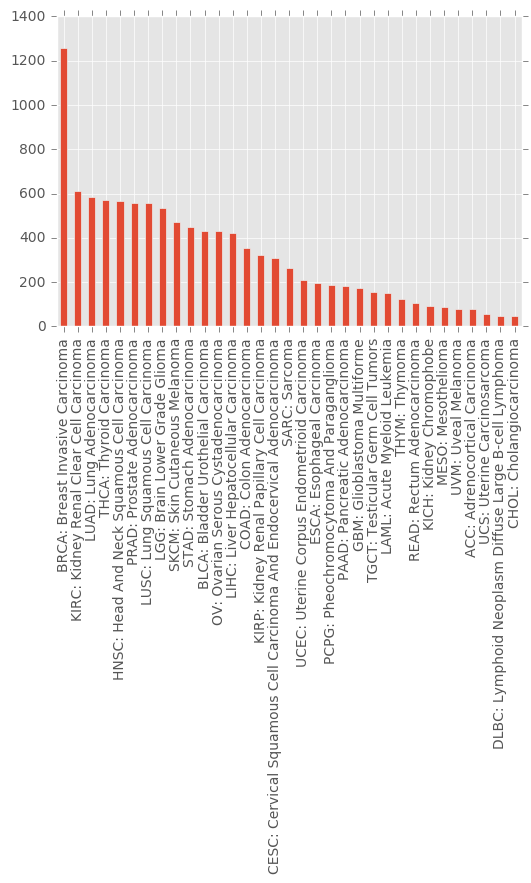

In [118]:
ndf.groupby('analysis_id').apply(lambda g: g.handy_disease_names.unique()[0]).value_counts().plot(kind='bar', rot=90)

In [119]:
ndf[['analysis_id', 'center']].drop_duplicates().center.value_counts()

UNC-LCCC    9272
BCCAGSC     1226
BI          170 
Name: center, dtype: int64

In [120]:
ndf[ndf.center != 'BCCAGSC'].GCSobject_ext.unique()

array(['.tar.gz'], dtype=object)

In [121]:
ndf[ndf.center == 'BCCAGSC'].GCSobject_ext.unique()

array(['.tar'], dtype=object)

In [122]:
ndf[ndf.center != 'BCCAGSC'].groupby('analysis_id').count().ix[:,1].unique()

array([2])

In [123]:
ndf[ndf.center == 'BCCAGSC'].groupby('analysis_id').count().ix[:,1].unique()

array([2, 4, 6])

In [124]:
ndf.sample_type_name.value_counts()

Primary solid Tumor                                18736
Solid Tissue Normal                                1458 
Metastatic                                         788  
Primary Blood Derived Cancer - Peripheral Blood    604  
Recurrent Solid Tumor                              100  
Additional - New Primary                           22   
Additional Metastatic                              2    
Name: sample_type_name, dtype: int64

In [125]:
s = ndf.groupby(['disease', 'sample_type_name']).count().ix[:, 0]

In [126]:
s.to_frame(name='count').to_csv('~/lele.tsv')

In [127]:
ndf.sample_type_code.value_counts()

01    18736
11    1458 
06    788  
03    604  
02    100  
05    22   
07    2    
Name: sample_type_code, dtype: int64

In [128]:
ndf.sample_type_code.astype

<bound method Series.astype of 2        01
3        01
4        01
5        01
6        01
7        01
8        01
9        01
10       01
11       01
12       11
13       11
14       01
15       01
16       01
17       01
18       01
19       01
20       01
21       01
22       01
23       01
24       01
25       01
28       11
29       11
30       01
31       01
32       01
33       01
         ..
22377    01
22378    01
22379    11
22380    11
22382    01
22383    01
22384    11
22385    11
22386    01
22387    01
22388    01
22389    01
22390    01
22391    01
22392    01
22393    01
22394    01
22395    01
22396    11
22397    11
22398    01
22399    01
22400    01
22401    01
22402    01
22403    01
22404    01
22405    01
22406    01
22407    01
Name: sample_type_code, dtype: object>

https://wiki.nci.nih.gov/display/TCGA/TCGA+barcode
>Tumor types range from 01 - 09, normal types from 10 - 19 and control samples from 20 - 29. See Code Tables Report for a complete list of sample codes 

In [129]:
def has_both_normal_and_tumor(grp):
    # sample type codes
    c = grp.sample_type_code.astype(int).unique()
    return (c[c <= 9].shape[0] > 0) and (c[c > 9].shape[0] > 0)

In [130]:
# Get index of participants with both normal and tumor samples
pars = ndf.groupby('participant_id').apply(has_both_normal_and_tumor)

In [131]:
pids = ndf[ndf.participant_id.isin(pars[pars].index)]

In [132]:
pids.participant_id.unique().shape

(679,)

In [133]:
pids.center.value_counts()

UNC-LCCC    2616
BCCAGSC     184 
Name: center, dtype: int64

In [134]:
s = pids.groupby(['participant_id', 'disease']).apply(lambda g: g.sample_type_code.values.shape[0])

In [135]:
s.head()

participant_id                        disease
00a02e62-e1ab-467a-91b3-5f526dd2251a  THCA       4
00e41e6a-9fe7-44f9-978b-7b05b179506a  PRAD       4
023a1ad1-fb16-437e-9806-5063b47f76bd  LIHC       4
028e99e9-5b9a-4954-bb6e-6d4709a3cea8  LUAD       4
02931491-f56b-4233-a079-812e08bc0c59  LIHC       4
dtype: int64

In [136]:
pids[['barcode', 'participant_id', 'disease', 'sample_type_name', 'sample_type_code', 'GCSobject']]\
.drop_duplicates()\
.sort_values(['participant_id', 'sample_type_code'])\
.to_csv('/home/zxue/for_readman.csv', index=False)

In [137]:
_d = pids[['barcode', 'participant_id', 'disease', 'sample_type_name', 'sample_type_code', 'GCSobject']]\
.drop_duplicates()

In [138]:
_lele = _d.groupby('participant_id').count().ix[:, 0]

In [139]:
_lele[_lele > 2]

participant_id
0c0b610e-fe4c-406d-a5ed-5cc3b11dabf5    4
0ea4920f-f4c8-4590-84b3-eb419824e144    3
17c1d42c-cb84-4655-a4cd-b54bae17ecaf    3
49929108-023e-4d35-b26d-50ab4d3ae581    4
4aa68586-6331-4795-b40c-859386640df6    3
4c6c8d3d-e4a3-490a-9211-cfbe7e6ee25b    4
556fcbc8-172a-4af1-8822-ae036e8d68e8    4
6b960b58-28e1-41c6-bd6e-7e669c6aa4ef    3
6cd9baf5-bbe0-4c1e-a87f-c53b3af22890    6
889aec8e-14ba-48d9-8fe1-f2416e82b333    4
8c7e74e0-71ef-49b8-9217-94b8ef740ef9    4
91e249a6-b0b0-487e-9fad-0e9f5798dcae    4
98d45099-feae-4dad-aa38-ec03fed6d999    4
bab43415-d413-40be-a4c0-2c40a52afe6a    4
cb9f5e50-f49d-4899-8895-9367afcc1015    8
ccda26c1-a6d6-4317-8cf8-8a87e15ce12e    4
da5b0169-e4f4-4674-b348-220af03ff4b5    4
ddeacccf-0953-4952-8a4e-c2617f2e7bcc    4
f130f376-5801-40f9-975d-a7e2f7b5670d    4
fb79c491-7b01-42ae-8369-8364e442e31b    4
Name: barcode, dtype: int64

In [140]:
_d.sample_type_code.value_counts()

01    716
11    680
06    4  
Name: sample_type_code, dtype: int64

In [141]:
_p = _d[_d.sample_type_code == '06'].participant_id

In [142]:
_p

8341     d3b77da8-be1d-4955-b1c7-55b7769785e8
18083    17c1d42c-cb84-4655-a4cd-b54bae17ecaf
19310    6b960b58-28e1-41c6-bd6e-7e669c6aa4ef
19685    4aa68586-6331-4795-b40c-859386640df6
Name: participant_id, dtype: object

In [143]:
_d.participant_id.unique().shape

(679,)

In [144]:
# _d[_d.participant_id.isin(_p)].sort_values(['participant_id', 'sample_type_code'])

In [145]:
ndf.AliquotUUID

2        180a84c1-99c0-4014-b42e-8e01f88980aa
3        180a84c1-99c0-4014-b42e-8e01f88980aa
4        731721fa-4ced-445d-855f-e4ded85f9726
5        731721fa-4ced-445d-855f-e4ded85f9726
6        28c5092b-901c-4bbb-9647-885bcfbe17f7
7        28c5092b-901c-4bbb-9647-885bcfbe17f7
8        a79de49e-9b1c-4512-b6ed-df4a858c4875
9        a79de49e-9b1c-4512-b6ed-df4a858c4875
10       818ed3ec-2c9c-41cc-8c01-18c9a95e9a02
11       818ed3ec-2c9c-41cc-8c01-18c9a95e9a02
12       dc79421f-367f-4be3-97ec-ea1dbb1e554c
13       dc79421f-367f-4be3-97ec-ea1dbb1e554c
14       5bcb5dd5-84a3-48fb-9942-e2f888cbd672
15       5bcb5dd5-84a3-48fb-9942-e2f888cbd672
16       85845e8c-e9d7-43c4-8dfc-d7fb0cf85ac5
17       85845e8c-e9d7-43c4-8dfc-d7fb0cf85ac5
18       a55363ab-18f6-4200-9c76-628786e26d11
19       a55363ab-18f6-4200-9c76-628786e26d11
20       8eac950a-dae0-4548-9f3b-ccda65e32f89
21       8eac950a-dae0-4548-9f3b-ccda65e32f89
22       70c7f658-5208-4b3f-9767-27a3b06b8ddc
23       70c7f658-5208-4b3f-9767-2

### Future processing of the data will be by center, starting with BI since it have the smallest number of samples, then UNC-LCCC.

# BI

In [146]:
bi_df = ndf[ndf.center == 'BI']

In [147]:
bi_df.GCSobject.unique().shape

(170,)

In [148]:
# So the mean is about 6GB
bi_df.objectSizeBytes.describe()

count    3.400000e+02
mean     6.898863e+09
std      9.992603e+08
min      4.102832e+09
25%      6.292599e+09
50%      6.849823e+09
75%      7.417438e+09
max      1.297000e+10
Name: objectSizeBytes, dtype: float64

In [149]:
bi_df.disease.value_counts()

GBM    340
Name: disease, dtype: int64

In [150]:
bi_df.disease_name.value_counts()

GLIOBLASTOMA MULTIFORME    340
Name: disease_name, dtype: int64

In [151]:
bi_df.maxLength.value_counts()

76    340
Name: maxLength, dtype: int64

In [152]:
bi_df.sort_values('objectSizeBytes').head(1)

,CGHub_analysisID,AliquotBarcode,fastqFilename,FastQC_html_url,FastQC_zip_url,BasicStats,numTotalSeq,numPoorSeq,minLength,maxLength,delLength,pctGC,SeqLenDist,SeqDupLev,Total_Dedup_Pct,OverrepSeq,AdaptCont,KmerCont,study,barcode,disease,disease_name,sample_type,sample_type_name,analyte_type,library_type,center,center_name,platform,platform_name,assembly,filename,files_size,checksum,analysis_id,aliquot_id,participant_id,sample_id,tss_id,sample_accession,published,uploaded,modified,state,sample_type_code,analyte_type_code,platform_full_name,file_type,reason,reagent_vendor,reagent_name,catalog_number,is_custom,target_file_url,probe_file_url,CGHubAnalysisID,AliquotUUID,GCSobject,objectSizeBytes,pretty_size,handy_disease_names,sstype,GCSobject_ext
13090,9579bb44-a931-46a9-ad86-784479904719,TCGA-14-0736-02A-01R-2005-01,G17467.TCGA-14-0736-02A-01R-2005-01.2.bam_1.fastq,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/GBM/RNA/RNA-Seq/BI/ILLUMINA/9579bb44-a931-46a9-ad86-784479904719-G17467.TCGA-14-0736-02A-01R-2005-01.2.bam_1_fastqc.html,https://storage.cloud.google.com/isb-cgc-open/tcga-qc/GBM/RNA/RNA-Seq/BI/ILLUMINA/9579bb44-a931-46a9-ad86-784479904719-G17467.TCGA-14-0736-02A-01R-2005-01.2.bam_1_fastqc.zip,pass,39321150,0,76,76,1,49,pass,fail,45.680475,fail,pass,fail,TCGA,TCGA-14-0736-02A-01R-2005-01,GBM,GLIOBLASTOMA MULTIFORME,TR,Recurrent Solid Tumor,RNA,RNA-Seq,BI,NaN,ILLUMINA,Illumina,unaligned,G17467.TCGA-14-0736-02A-01R-2005-01.2.tar.gz,4.102832e+09,dc81b685776f5d12efa03c37ae81493c,9579bb44-a931-46a9-ad86-784479904719,b469eb7c-723f-4870-b4e4-ebfaae7a118b,cdfcf14d-ed6c-419f-88f5-e7dee96fcaf6,c0926a99-c67b-4793-b731-8fdc3eef96eb,14,NaN,2013-12-16,2013-12-16,2013-12-16,Live,02,R,Illumina HiSeq 2000,fasta,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9579bb44-a931-46a9-ad86-784479904719,b469eb7c-723f-4870-b4e4-ebfaae7a118b,gs://5aa919de-0aa0-43ec-9ec3-288481102b6d/tcga/GBM/RNA/RNA-Seq/BI/ILLUMINA/G17467.TCGA-14-0736-02A-01R-2005-01.2.tar.gz,4102832413,3.8GB,GBM: Glioblastoma Multiforme,tumour,.tar.gz


In [153]:
bi_df.sort_values('objectSizeBytes')[['GCSobject', 'pretty_size', 'maxLength']].\
    drop_duplicates().to_csv('bi_gcs_objects.csv', sep='\t', index=False)

# BCCAGSC

In [154]:
gsc_df = ndf[ndf.center == 'BCCAGSC']

In [155]:
gsc_df.objectSizeBytes.describe()

count    2.826000e+03
mean     1.190733e+10
std      4.973603e+09
min      3.286098e+09
25%      7.009208e+09
50%      1.247165e+10
75%      1.566970e+10
max      2.972934e+10
Name: objectSizeBytes, dtype: float64

In [156]:
gsc_df.maxLength.value_counts()

75     2090
50     732 
100    4   
Name: maxLength, dtype: int64

In [157]:
', '.join(sorted(gsc_df.disease.value_counts().index.values))

'ESCA, LAML, OV, STAD'

In [158]:
gsc_df.GCSobject.unique().shape

(1226,)

In [159]:
gsc_df.sort_values('objectSizeBytes')[['GCSobject', 'pretty_size', 'maxLength']].\
    drop_duplicates().to_csv('gsc_gcs_objects.csv', sep='\t', index=False)

# UNC-LCCC

In [160]:
unc_df = ndf[ndf.center == 'UNC-LCCC']

In [161]:
unc_df.maxLength.value_counts()

48    14890
50    3654 
Name: maxLength, dtype: int64

In [162]:
unc_df.GCSobject.unique().shape

(9272,)

In [164]:
', '.join(sorted(unc_df.disease.value_counts().index.values))

'ACC, BLCA, BRCA, CESC, CHOL, COAD, DLBC, GBM, HNSC, KICH, KIRC, KIRP, LGG, LIHC, LUAD, LUSC, MESO, PAAD, PCPG, PRAD, READ, SARC, SKCM, TGCT, THCA, THYM, UCEC, UCS, UVM'

In [129]:
unc_df.sort_values('objectSizeBytes')[['GCSobject', 'pretty_size', 'maxLength']].\
    drop_duplicates().to_csv('unc_gcs_objects.csv', sep='\t', index=False)

#### Object size distribution

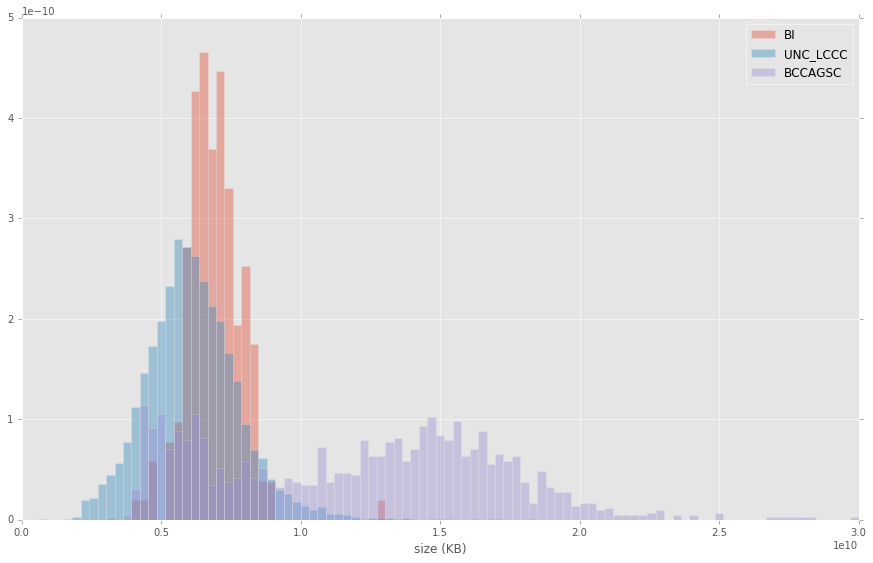

In [130]:
fig = plt.figure()
ax = fig.add_subplot(111)

bins = np.linspace(0, 3e10, 100)
ax.hist(bi_df.objectSizeBytes.values, bins=bins, normed=True, alpha=0.4, label='BI')
ax.hist(unc_df.objectSizeBytes.values, bins=bins, normed=True, alpha=0.4, label='UNC_LCCC')
ax.hist(gsc_df.objectSizeBytes.values, bins=bins, normed=True, alpha=0.4, label='BCCAGSC')
ax.legend()
ax.set_xlabel('size (KB)')

### Generate a `metadata.csv` for handy querying based on filename

In [131]:
ndf.columns.shape

(62,)

In [132]:
print('\n'.join(sorted(ndf.columns, key=lambda x: x.lower())))

AdaptCont
aliquot_id
AliquotBarcode
AliquotUUID
analysis_id
analyte_type
analyte_type_code
assembly
barcode
BasicStats
catalog_number
center
center_name
CGHub_analysisID
CGHubAnalysisID
checksum
delLength
disease
disease_name
FastQC_html_url
FastQC_zip_url
fastqFilename
file_type
filename
files_size
GCSobject
GCSobject_ext
handy_disease_names
is_custom
KmerCont
library_type
maxLength
minLength
modified
numPoorSeq
numTotalSeq
objectSizeBytes
OverrepSeq
participant_id
pctGC
platform
platform_full_name
platform_name
pretty_size
probe_file_url
published
reagent_name
reagent_vendor
reason
sample_accession
sample_id
sample_type
sample_type_code
sample_type_name
SeqDupLev
SeqLenDist
state
study
target_file_url
Total_Dedup_Pct
tss_id
uploaded


In [133]:
ndf.sample_type_code.value_counts()

01    18736
11    1458 
06    788  
03    604  
02    100  
05    22   
07    2    
Name: sample_type_code, dtype: int64

In [134]:
ndf.sample_type_name.value_counts()

Primary solid Tumor                                18736
Solid Tissue Normal                                1458 
Metastatic                                         788  
Primary Blood Derived Cancer - Peripheral Blood    604  
Recurrent Solid Tumor                              100  
Additional - New Primary                           22   
Additional Metastatic                              2    
Name: sample_type_name, dtype: int64

In [248]:
ndf['sstype'] = ndf.apply(lambda r: 'normal' if r.sample_type == 'NT' else 'tumour', axis=1)

In [249]:
ndf.sstype.value_counts()

tumour    20252
normal    1458 
Name: sstype, dtype: int64

In [251]:
ndf[['analysis_id', 'sstype']].drop_duplicates().sstype.value_counts()

tumour    9939
normal    729 
Name: sstype, dtype: int64

In [252]:
9939 + 729

10668

In [253]:
729 / 9939.

0.07334741925747057

In [135]:
ndf.sample_type.value_counts()

TP     18736
NT     1458 
TM     788  
TB     604  
TR     100  
TAP    22   
TAM    2    
Name: sample_type, dtype: int64

In [136]:
ndf[['analysis_id', 'barcode', 'disease', 'disease_name',
     'sample_type', 'sample_type_code', 'sample_type_name',
     'pretty_size', 'maxLength', 'GCSobject']]\
.drop_duplicates().sort_values('analysis_id').to_csv('metadata.csv', index=False)

In [139]:
sizeof_fmt(ndf[['files_size', 'GCSobject']].drop_duplicates().files_size.sum())

'67.1TB'

In [140]:
sizeof_fmt(ndf[['objectSizeBytes', 'GCSobject']].drop_duplicates().objectSizeBytes.sum())

'67.1TB'

## fixing failed runs

In [141]:
ids = []
with open('/projects/btl2/zxue/tasrkleat/TCGA-results/lele') as inf:
    for line in inf:
        i = 0
        while i < 3:
            line = os.path.dirname(line)
            i += 1
        id_ = os.path.basename(line)
        ids.append(id_)

FileNotFoundError: [Errno 2] No such file or directory: '/projects/btl2/zxue/tasrkleat/TCGA-results/lele'

In [ ]:
udf = ndf[-ndf.filename.isin(ids)]

In [ ]:
udf = udf.copy()

In [ ]:
udf.analysis_id.unique().shape

In [ ]:
udf.filename.head()

In [ ]:
udf.head(2)

In [ ]:
# from googleapiclient import discovery
# from googleapiclient import http

# from oauth2client.client import GoogleCredentials

# credentials = GoogleCredentials.get_application_default()

# service = discovery.build('storage', 'v1', credentials=credentials)

# service.objects().

In [ ]:
udf_logs = udf.GCSobject.apply(lambda x: re.sub(r'gs://[^/]+', 'gs://tasrkleat', x ) + '/logs').unique()

In [ ]:
with open('/projects/btl2/zxue/tasrkleat/TCGA-results/no_output.txt', 'wt') as opf:
    for _ in sorted(udf_logs):
        opf.write('{0}\n'.format(_))

In [ ]:
udf.head(1)

In [ ]:
udf[['analysis_id', 'center']].drop_duplicates().center.value_counts()

In [ ]:
udf.drop(udf[udf.center == 'BCCAGSC'].index, inplace=True)

In [ ]:
udf.shape

In [ ]:
udf.sort_values('objectSizeBytes')[['GCSobject', 'pretty_size', 'maxLength']].\
    drop_duplicates().to_csv('missing_runs_gcs_objects.csv', sep='\t', index=False)

In [ ]:
ndf[ndf.GCSobject.str.contains('TCGA-AB-2992-03A-01T-0735-13_rnaseq_fastq.tar')]

In [258]:
ndf[['disease', 'disease_name', 'handy_disease_names']].drop_duplicates().sort_values('disease')

,disease,disease_name,handy_disease_names
2,ACC,ADRENOCORTICAL CARCINOMA,ACC: Adrenocortical Carcinoma
22,BLCA,BLADDER UROTHELIAL CARCINOMA,BLCA: Bladder Urothelial Carcinoma
16,BRCA,BREAST INVASIVE CARCINOMA,BRCA: Breast Invasive Carcinoma
24,CESC,CERVICAL SQUAMOUS CELL CARCINOMA AND ENDOCERVICAL ADENOCARCINOMA,CESC: Cervical Squamous Cell Carcinoma And Endocervical Adenocarcinoma
90,CHOL,CHOLANGIOCARCINOMA,CHOL: Cholangiocarcinoma
82,COAD,COLON ADENOCARCINOMA,COAD: Colon Adenocarcinoma
712,DLBC,LYMPHOID NEOPLASM DIFFUSE LARGE B-CELL LYMPHOMA,DLBC: Lymphoid Neoplasm Diffuse Large B-cell Lymphoma
64,ESCA,ESOPHAGEAL CARCINOMA,ESCA: Esophageal Carcinoma
60,GBM,GLIOBLASTOMA MULTIFORME,GBM: Glioblastoma Multiforme
32,HNSC,HEAD AND NECK SQUAMOUS CELL CARCINOMA,HNSC: Head And Neck Squamous Cell Carcinoma


In [36]:
ndf.columns.tolist()

['CGHub_analysisID',
 'AliquotBarcode',
 'fastqFilename',
 'FastQC_html_url',
 'FastQC_zip_url',
 'BasicStats',
 'numTotalSeq',
 'numPoorSeq',
 'minLength',
 'maxLength',
 'delLength',
 'pctGC',
 'SeqLenDist',
 'SeqDupLev',
 'Total_Dedup_Pct',
 'OverrepSeq',
 'AdaptCont',
 'KmerCont',
 'study',
 'barcode',
 'disease',
 'disease_name',
 'sample_type',
 'sample_type_name',
 'analyte_type',
 'library_type',
 'center',
 'center_name',
 'platform',
 'platform_name',
 'assembly',
 'filename',
 'files_size',
 'checksum',
 'analysis_id',
 'aliquot_id',
 'participant_id',
 'sample_id',
 'tss_id',
 'sample_accession',
 'published',
 'uploaded',
 'modified',
 'state',
 'sample_type_code',
 'analyte_type_code',
 'platform_full_name',
 'file_type',
 'reason',
 'reagent_vendor',
 'reagent_name',
 'catalog_number',
 'is_custom',
 'target_file_url',
 'probe_file_url',
 'CGHubAnalysisID',
 'AliquotUUID',
 'GCSobject',
 'objectSizeBytes',
 'pretty_size',
 'handy_disease_names',
 'sstype']